# Activity and RV modelling with george, celerite, and RadVel

In [1]:
import pprint

import arviz as az
import corner
import emcee
import george
import matplotlib.pyplot as plt
import numpy as np
import radvel
import scipy.optimize as op
from astropy.table import Table
from george import kernels
from george.gp import LinAlgError
from radvel.plot import mcmc_plots, orbit_plots
import nirps_tools as nirps
import tqdm
import yaml

## System info

In [2]:
star = input('Enter star name:')

print('Loading input file and data...')
### System info
working_path = f"stars/{star}/"

# Read input file
try: 
    with open(working_path + 'input.yaml', 'r') as file:
        data = yaml.safe_load(file)
except FileNotFoundError:
    print('This star does not exist in the database.')
    raise


Loading input file and data...


## Loading data

In [3]:
# Extract data from 'data' dictionary
star_info = data['star']  # Initialize as a list of one empty dictionary if no star data found
instruments = data['instruments']
activity_priors = data['activity_priors']
RV_priors = data['RV_priors']
ccf = data['CCF']
version = 'DRS-3-0-0' # Version of the HARPS pipeline

# Dictionaries to store the LBL data
tbl = {}
t_rv, y_rv, yerr_rv = {}, {}, {}
d2v, sd2v, Dtemp, sDtemp = {}, {}, {}, {}
med_rv_nirps = {}
t_mod = {}
rjd_bjd_off = 2400000.5

# Dictionaries to store the CCF data
tbl_ccf = {}
t_ccf = {}
t_mod_ccf = {}
fwhm = {}
sig_fwhm = {}
y_rv_ccf = {}
yerr_rv_ccf = {}
instruments_ccf = list(tbl_ccf.keys())

hnames = ['gp_amp', 'gp_explength', 'gp_per', 'gp_perlength']

i = 0
for instrument in instruments:
    star_name = star_info.get('name', '')  # Accessing the first element of the star_info list
    ref_star = instruments[instrument].get('ref_star', '')
    suffix = instruments[instrument].get('dtemp_suffix', '')
    bin_label = instruments[instrument].get('bin_label', '')
    pca_label = instruments[instrument].get('pca_label', '')
    
    tbl[instrument] = Table.read(f'stars/{star_name}/data/lbl{bin_label}_{instrument}_{star_name}_{ref_star}{pca_label}_preprocessed.rdb', format='rdb')
    
    # RV data    
    t_rv[instrument], y_rv[instrument], yerr_rv[instrument] = tbl[instrument]['rjd'] , tbl[instrument]['vrad'], tbl[instrument]['svrad']
    t_rv[instrument] += rjd_bjd_off

    # Stellar activity indicators
    d2v[instrument], sd2v[instrument] = tbl[instrument]['d2v']/np.max(tbl[instrument]['d2v']), np.abs(tbl[instrument]['sd2v']/np.max(tbl[instrument]['d2v']))
    d2v[instrument] -= np.median(d2v[instrument])
    Dtemp[instrument], sDtemp[instrument] = tbl[instrument]['DTEMP'+suffix], tbl[instrument]['sDTEMP'+suffix]
    Dtemp[instrument] -= np.median(Dtemp[instrument])

    # Median of the RVs
    med_rv_nirps[instrument] = np.rint(np.median(tbl[instrument]['vrad'].data))
    t_mod[instrument] = np.linspace(np.min(t_rv[instrument]), np.max(t_rv[instrument]), 1000)
    i += 1
    
# # Get the CCF data if it exists
for instrument in instruments_ccf:
    tbl_ccf[instrument] = {}
    if ccf[instrument][version]: 
        # Read the CCF data
        tbl_ccf[instrument][version] = Table.read(f'stars/{star}/data/{star}_{instrument}_DRS-3-0-0.rdb', format='rdb')
        
        # Instances of the data
        t_ccf[instrument] = tbl_ccf[instrument][version]["rjd"] + rjd_bjd_off
        t_mod_ccf[instrument] = np.linspace(np.min(t_ccf[instrument]), np.max(t_ccf[instrument]), 1000)
        fwhm[instrument] = tbl_ccf[instrument][version]['fwhm']
        sig_fwhm[instrument] = tbl_ccf[instrument][version]['sig_fwhm']
        y_rv_ccf[instrument] = tbl_ccf[instrument][version]['vrad']
        yerr_rv_ccf[instrument] = tbl_ccf[instrument][version]['sig_vrad']
    

In [4]:
# try:
#     tc2_guess = star_info['planets']['b']['t_mid'] - rjd_bjd_off - extra_off
#     RV_priors['tc2']['guess'] = tc2_guess
# except: 
#     pass

## Activity modelling

### Defining a GP model
We'll define our first GP model with `george`. The package is in maintenance mode and
there are more efficient and modern alternatives (including some by the same authors),
but it is still extensively used and provides a simple interface to understand how GPs
work in practice.

We first need to define a covariance function. We'll use a quasi-periodic kernel made
of a square exponential and a periodic kernel. This is one of the first kernels that
were used for this type of work (QP-GP kernel).




In [5]:
def activity_indicator(t, t_mod, y, yerr, instruments, activity_label = 'd2v'): 
    
    print(f'Computing {activity_label} guess...')
    gp = {}
    results = {}
    kernel = {}

    fig, axes = plt.subplots(len(instruments), 1, figsize=(10, 6), sharex=True)

    i=0
    for instrument in instruments: 
        # QP-GP hyperparameters
        amp = np.std(y[instrument])# Amplitude of the kernel
        length_scale = activity_priors['GP_length']['guess']# Length scale
        gamma = activity_priors['GP_gamma']['guess'] #Harmonic complexity
        log_period = np.log(activity_priors['GP_Prot']['guess']) # Log of the period

        # Exponential kernel
        ker_sqexp = kernels.ExpSquaredKernel(metric=length_scale**2)  # note the **2 here

        #Sinus squared kernel
        ker_per = kernels.ExpSine2Kernel(gamma=gamma, log_period=log_period)

        # QP-GP kernel
        kernel[instrument] = amp**2 * ker_sqexp * ker_per

        gp[instrument] = {}
        mean_val = np.mean(y[instrument]) 
        log_wn_var = np.log(0.1**2) #white noise variance

        gp[instrument] = george.GP(
            kernel[instrument],
            mean=mean_val,
            fit_mean=True,
            white_noise=log_wn_var,
            fit_white_noise=True,
            # fit_white_noise=False,
        )
        
        def nll(p: np.ndarray[float]) -> float:
            gp[instrument].set_parameter_vector(p)
            ll = gp[instrument].log_likelihood(y[instrument], quiet=True)
            return -ll if np.isfinite(ll) else 1e25

        # This pre-compute the covariance matrix
        gp[instrument].compute(t[instrument], yerr=yerr[instrument])

        print(f"Initial log-likelihood: {gp[instrument].log_likelihood(y[instrument])}")
        print("Initial parameters:")
        pprint.pprint(gp[instrument].get_parameter_dict())

        p0 = gp[instrument].get_parameter_vector()
        results[instrument] = op.minimize(nll, p0, method="Powell")

        gp[instrument].set_parameter_vector(results[instrument].x)
        
        print(f"Final log-likelihood: {gp[instrument].log_likelihood(y[instrument])}")
        print("Final parameters:")
        pprint.pprint(gp[instrument].get_parameter_dict())

        mu, var = gp[instrument].predict(y[instrument], t_mod[instrument], return_var=True)
        std = np.sqrt(var)
        
        if len(instruments)==1: 
            axes.errorbar(t[instrument], y[instrument], yerr=yerr[instrument], fmt="k.")
            axes.plot(t_mod[instrument], mu)
            axes.fill_between(t_mod[instrument], mu - std, mu + std, alpha=0.2, color="C0")
            axes.set_title(instrument)
            axes.set_ylabel(activity_label)
            axes.set_xlabel(f"Time [BJD]")

        else:
            axes[i].errorbar(t[instrument], y[instrument], yerr=yerr[instrument], fmt="k.")
            axes[i].plot(t_mod[instrument], mu)
            axes[i].fill_between(t_mod[instrument], mu - std, mu + std, alpha=0.2, color="C0")
            axes[i].set_title(instrument)
            axes[i].set_ylabel(activity_label)
            axes[1].set_xlabel(f"Time [BJD]")
        
        print(f'The period of the star predicted by Dtemp is {np.exp(gp[instrument].get_parameter_dict()["kernel:k2:log_period"]):.2f} days for {instrument}')
        
        i+=1
        
    plt.savefig(f"stars/{star}/george_radvel/activity/{activity_label}_GP_first_guess.png")
    plt.show()
    
    return gp, results

Second derivative 

Computing d2v guess...
Initial log-likelihood: 240.0878784916273
Initial parameters:
OrderedDict([('mean:value', 0.13947398023569657),
             ('white_noise:value', -4.605170185988091),
             ('kernel:k1:k1:log_constant', -1.5264142329595398),
             ('kernel:k1:k2:metric:log_M_0_0', 9.210340371976184),
             ('kernel:k2:gamma', 1.0),
             ('kernel:k2:log_period', 4.499809670330265)])
Final log-likelihood: 299.2231938701217
Final parameters:
OrderedDict([('mean:value', 0.2557877727983955),
             ('white_noise:value', -5.582958234768976),
             ('kernel:k1:k1:log_constant', -1.620257220074295),
             ('kernel:k1:k2:metric:log_M_0_0', 9.119256404711752),
             ('kernel:k2:gamma', 6.997615845444201),
             ('kernel:k2:log_period', 4.44547524998537)])
The period of the star predicted by Dtemp is 85.24 days for NIRPS
Initial log-likelihood: -27.08523224006376
Initial parameters:
OrderedDict([('mean:value', 0.025033104785420

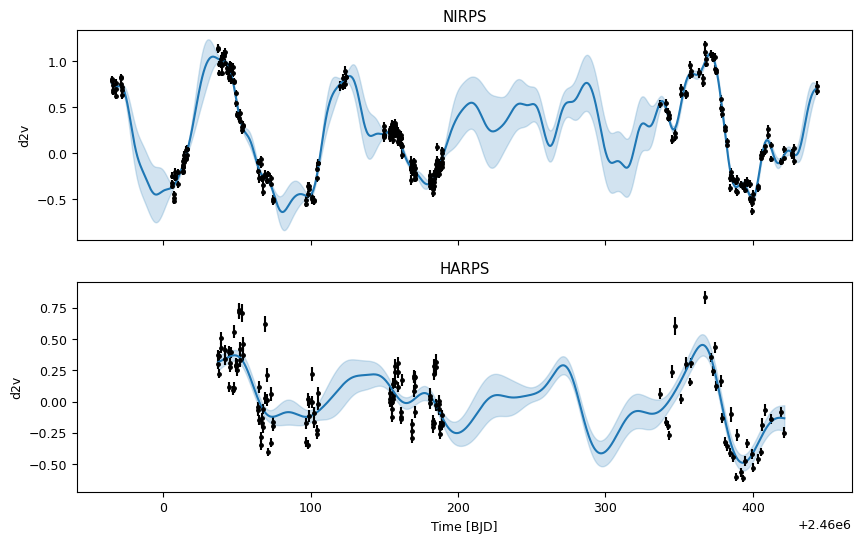

In [6]:
gp_d2v, results_d2v = activity_indicator(t_rv, t_mod, d2v, sd2v, instruments, activity_label='d2v')

Dtemp

Computing Dtemp guess...
Initial log-likelihood: -582.246059635356
Initial parameters:
OrderedDict([('mean:value', -0.23376074530982902),
             ('white_noise:value', -4.605170185988091),
             ('kernel:k1:k1:log_constant', 1.9680949621787773),
             ('kernel:k1:k2:metric:log_M_0_0', 9.210340371976184),
             ('kernel:k2:gamma', 1.0),
             ('kernel:k2:log_period', 4.499809670330265)])


Final log-likelihood: -299.7944929917513
Final parameters:
OrderedDict([('mean:value', -0.7599902977274396),
             ('white_noise:value', -1.8136298794888892),
             ('kernel:k1:k1:log_constant', 1.9313915110736248),
             ('kernel:k1:k2:metric:log_M_0_0', 9.440051650083577),
             ('kernel:k2:gamma', 6.143655951363658),
             ('kernel:k2:log_period', 4.4579236510136715)])
The period of the star predicted by Dtemp is 86.31 days for NIRPS
Initial log-likelihood: -2291.74496633177
Initial parameters:
OrderedDict([('mean:value', 1.023427673985644),
             ('white_noise:value', -4.605170185988091),
             ('kernel:k1:k1:log_constant', 3.461369505127601),
             ('kernel:k1:k2:metric:log_M_0_0', 9.210340371976184),
             ('kernel:k2:gamma', 1.0),
             ('kernel:k2:log_period', 4.499809670330265)])
Final log-likelihood: -437.437224418591
Final parameters:
OrderedDict([('mean:value', -0.5021751287976309),
             ('white_n

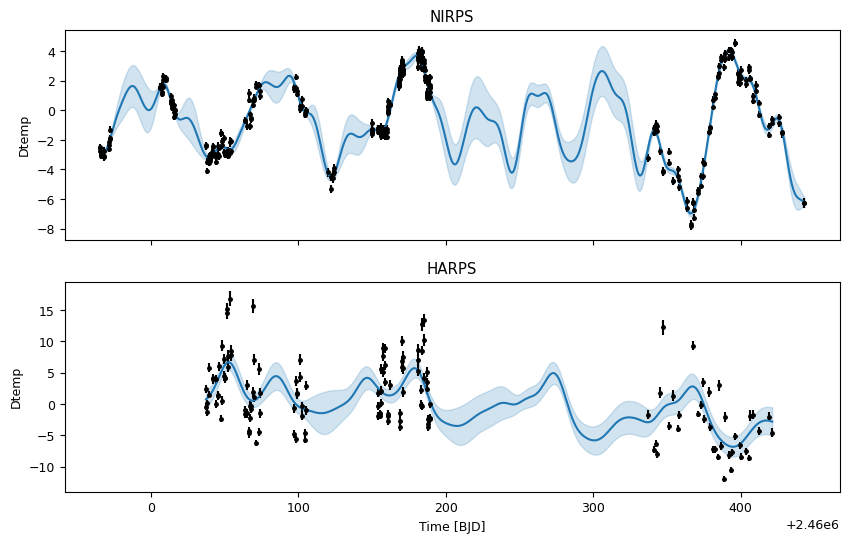

In [7]:
gp_Dtemp, results_Dtemp = activity_indicator(t_rv, t_mod, Dtemp, sDtemp, instruments, activity_label='Dtemp')

CCF indicators

FWHM

In [8]:
if t_ccf: # Check if there is CCF data
    gp_fwhm, results_fwhm = activity_indicator(t_ccf, t_mod_ccf, fwhm, sig_fwhm, instruments_ccf, activity_label='fwhm')

bissector

In [9]:
if t_ccf: # Check if there is CCF data
    gp_bis_span, results_bis_span = activity_indicator(t_ccf, t_mod_ccf, bis_span, sig_bis_span, instruments_ccf, activity_label='bis_span')

### Hyperparameter optimization
We can now optimize the hyperparameters with scipy to get the best-fit model.

Note how the gamma parameter is larger than our initial guess for the best fit.
This means the likelihood is improved by giving more flexibility to the model
to handle short term variations. There is still a periodicity around 90 days.

### Hyperparameter sampling
Here, we'll use `emcee` to sample the posterior distribution of our simple model.
We could also use `george` with a nested sampling package, but it would require
implementing a prior transform, which I won't get into here.

First, we'll need to define our prior distribution.
I'll print the order of parameters in the next cell for convenience,
then define distributions and the  model prior.

Choosing activity indicator

In [10]:
chosen_activity = activity_priors['chosen_activity']
if chosen_activity == 'Dtemp':
    act_label = 'Dtemp'
    gp_act = gp_Dtemp
    act_data = Dtemp
    act_err = sDtemp
    results_act = results_Dtemp
    print('Dtemp chosen')
    
elif chosen_activity == 'd2v':
    act_label = 'd2v'
    gp_act = gp_d2v
    act_data = d2v
    act_err = sd2v
    results_act = results_d2v
    print('d2v chosen')
    
elif chosen_activity == 'fwhm':
    act_label = 'fwhm'
    gp_act = gp_fwhm
    act_data = fwhm
    act_err = sig_fwhm
    results_act = results_fwhm
    print('fwhm chosen')

elif chosen_activity == 'bis_span':
    act_label = 'bis_span'
    gp_act = gp_bis_span
    act_data = bis_span
    act_err = sig_bis_span
    results_act = results_bis_span
    print('bis_span chosen')

else: 
    raise ValueError('Activity indicator not recognized')

d2v chosen


Computing priors

In [11]:
print('Computing priors...')

def gaussian_logp(x: float, mu: float, sigma: float) -> float:
    # Copied from radvel for convenience
    return -0.5 * ((x - mu) / sigma) ** 2 - 0.5 * np.log((sigma**2) * 2.0 * np.pi)


def uniform_logp(x: float, minval: float, maxval: float) -> float:
    # Copied from radvel for convenience
    if x <= minval or x >= maxval:
        return -np.inf
    else:
        return -np.log(maxval - minval)


def jeffreys_logp(x: float, minval: float, maxval: float) -> float:
    # Copied from radvel for convenience
    normalization = 1.0 / np.log(maxval / minval)
    if x < minval or x > maxval:
        return -np.inf
    else:
        return np.log(normalization) - np.log(x)


def mod_jeffreys_logp(x: float, minval: float, maxval: float, kneeval: float) -> float:
    normalization = 1.0 / np.log((maxval - kneeval) / (minval - kneeval))
    if (x > maxval) or (x < minval):
        return -np.inf
    else:
        return np.log(normalization) - np.log(x - kneeval)


def log_prior(p: np.ndarray) -> float:
    log_prob = 0.0
    # Mean with wide prior around 0
    if activity_priors['mu']['distribution'] == 'Uniform':
        log_prob += uniform_logp(p[0], activity_priors['mu']['min'], activity_priors['mu']['max'])
    elif activity_priors['mu']['distribution'] == 'loguniform':
        log_prob += jeffreys_logp(p[0], activity_priors['mu']['min'], activity_priors['mu']['max'])
    elif activity_priors['mu']['distribution'] == 'Normal':
        log_prob += gaussian_logp(p[0], activity_priors['mu']['mean'], activity_priors['mu']['std'])
    else:
        raise ValueError(f'Distribution not recognized for mu')
    
    # Log White noise: Uniform
    if activity_priors['noise']['distribution'] == 'Uniform':
        log_prob += uniform_logp(p[1], np.log(activity_priors['noise']['min']**2), np.log(activity_priors['noise']['max']**2))
    elif activity_priors['noise']['distribution'] == 'loguniform':
        log_prob += jeffreys_logp(p[1], np.log(activity_priors['noise']['min']**2), np.log(activity_priors['noise']['max']**2))
    elif activity_priors['noise']['distribution'] == 'Normal':
        log_prob += gaussian_logp(p[1], np.log(activity_priors['noise']['mean']**2), np.log(activity_priors['noise']['std']**2))
    else:
        raise ValueError('Distribution not recognized for white noise')
    
    # Log Variance: Uniform
    if activity_priors['GP_sigma']['distribution'] == 'Uniform':
        log_prob += uniform_logp(p[2], np.log(activity_priors['GP_sigma']['min']**2), np.log(activity_priors['GP_sigma']['max']**2))
    elif activity_priors['GP_sigma']['distribution'] == 'loguniform':
        log_prob += jeffreys_logp(p[2], np.log(activity_priors['GP_sigma']['min']**2), np.log(activity_priors['GP_sigma']['max']**2))
    elif activity_priors['GP_sigma']['distribution'] == 'Normal':
        log_prob += gaussian_logp(p[2], np.log(activity_priors['GP_sigma']['mean']**2), np.log(activity_priors['GP_sigma']['std']**2))
    else: 
        raise ValueError('Distribution not recognized for amplitude')
    
    # Log metric (lambda**2): Uniform
    if activity_priors['GP_length']['distribution'] == 'Uniform':
        log_prob += uniform_logp(p[3], np.log(activity_priors['GP_length']['min']**2), np.log(activity_priors['GP_length']['max']**2))
    elif activity_priors['GP_length']['distribution'] == 'loguniform':
        log_prob += jeffreys_logp(p[3], np.log(activity_priors['GP_length']['min']**2), np.log(activity_priors['GP_length']['max']**2))
    elif activity_priors['GP_length']['distribution'] == 'Normal':
        log_prob += gaussian_logp(p[3], np.log(activity_priors['GP_length']['mean']**2), np.log(activity_priors['GP_length']['std']**2))
    else:
        raise ValueError('Distribution not recognized for length scale')
    
    # Gamma: Jeffreys prior
    if activity_priors['GP_gamma']['distribution'] == 'Uniform':
        log_prob += uniform_logp(p[4], activity_priors['GP_gamma']['min'], activity_priors['GP_gamma']['max'])
    elif activity_priors['GP_gamma']['distribution'] == 'loguniform':
        log_prob += jeffreys_logp(p[4], activity_priors['GP_gamma']['min'], activity_priors['GP_gamma']['max'])
    elif activity_priors['GP_gamma']['distribution'] == 'Normal':
        log_prob += gaussian_logp(p[4], activity_priors['GP_gamma']['mean'], activity_priors['GP_gamma']['std'])
    else:
        raise ValueError('Distribution not recognized for gamma')
    
    # Log Period: Uniform
    if activity_priors['GP_Prot']['distribution'] == 'Uniform':
        log_prob += uniform_logp(p[5], np.log(activity_priors['GP_Prot']['min']), np.log(activity_priors['GP_Prot']['max']))
    elif activity_priors['GP_Prot']['distribution'] == 'loguniform':
        log_prob += jeffreys_logp(p[5], np.log(activity_priors['GP_Prot']['min']), np.log(activity_priors['GP_Prot']['max']))
    elif activity_priors['GP_Prot']['distribution'] == 'Normal':
        log_prob += gaussian_logp(p[5], np.log(activity_priors['GP_Prot']['mean']), np.log(activity_priors['GP_Prot']['std']))
    else:
        raise ValueError('Distribution not recognized for log period')
    
    
    return log_prob

Computing priors...


In [12]:
def sample_from_prior(num_samples):
    """
    Function to sample from the prior distribution
    
    """
    prior_samples = []
    for _ in range(num_samples):
        sample = [
            np.random.normal(activity_priors['mu']['mean'] , activity_priors['mu']['std']),  # Sample from a Gaussian prior with mean 0 and std 5
            np.random.uniform(np.log(activity_priors['noise']['min']**2) , np.log(activity_priors['noise']['max']**2)),  # Sample from a uniform prior between -10 and 10
            # Add sampling logic for other parameters here based on your prior distributions
            # For example:
            np.random.uniform(np.log(activity_priors['GP_sigma']['min']**2), np.log(activity_priors['GP_sigma']['max']**2)),  # Example uniform prior
            np.random.uniform(np.log(activity_priors['GP_length']['min']**2), np.log(activity_priors['GP_length']['max']**2)),  # Example uniform prior
            np.random.uniform(activity_priors['GP_gamma']['min'], activity_priors['GP_gamma']['max']),  # Example uniform prior
            np.random.uniform(np.log(activity_priors['GP_Prot']['min']), np.log(activity_priors['GP_Prot']['max'])),  # Example loguniform prior
        ]
        prior_samples.append(sample)
    return np.array(prior_samples)

# Posterior function
def log_post(p: np.ndarray, gp, act) -> float:
    log_prob = log_prior(p)
    if np.isfinite(log_prob):
        gp.set_parameter_vector(p)
        return log_prob + gp.log_likelihood(act, quiet=True)
    return -np.inf

Now that we have defined our probabilistic model, we can do inference on the
parameters.

First, let's do a quick check that our prior is what we expect and gives models that
look OK. This is called a prior predictive check.

We'll use corner and Arviz to visualize our posterior.

Choosing activity indicator

Running prior predictive check


  5%|▍         | 466/10200 [00:00<00:16, 576.79it/s]

100%|██████████| 10200/10200 [00:17<00:00, 577.84it/s]


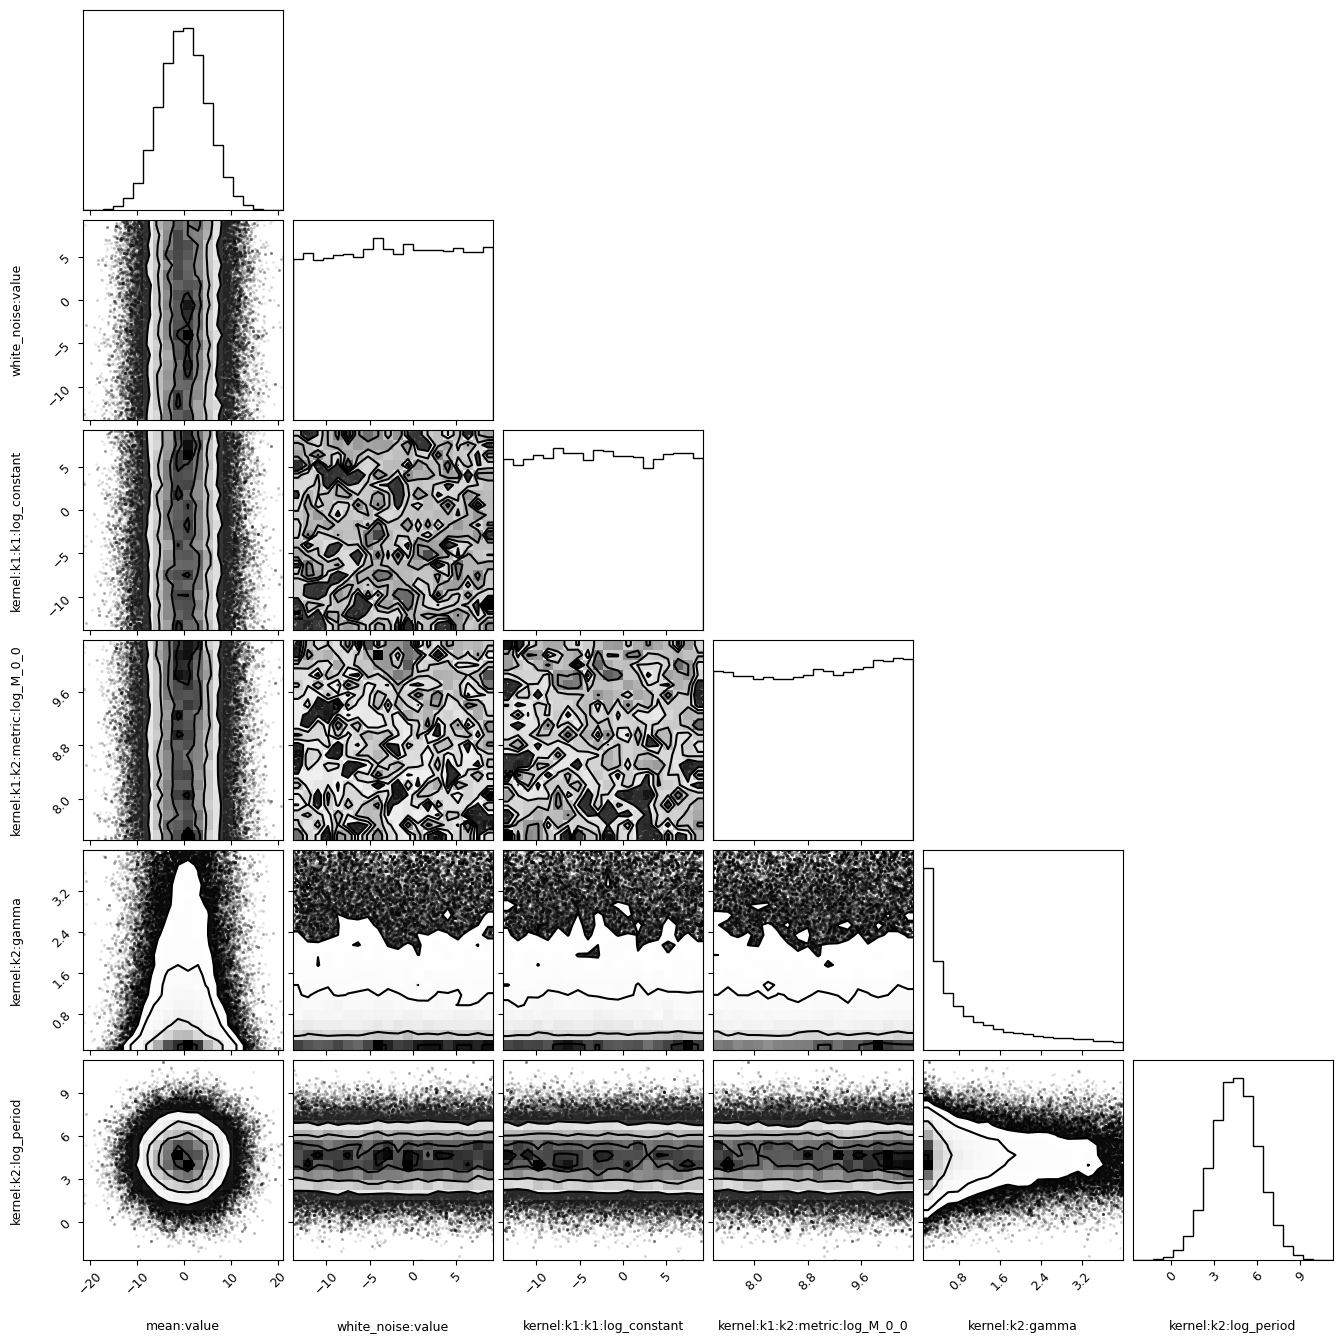

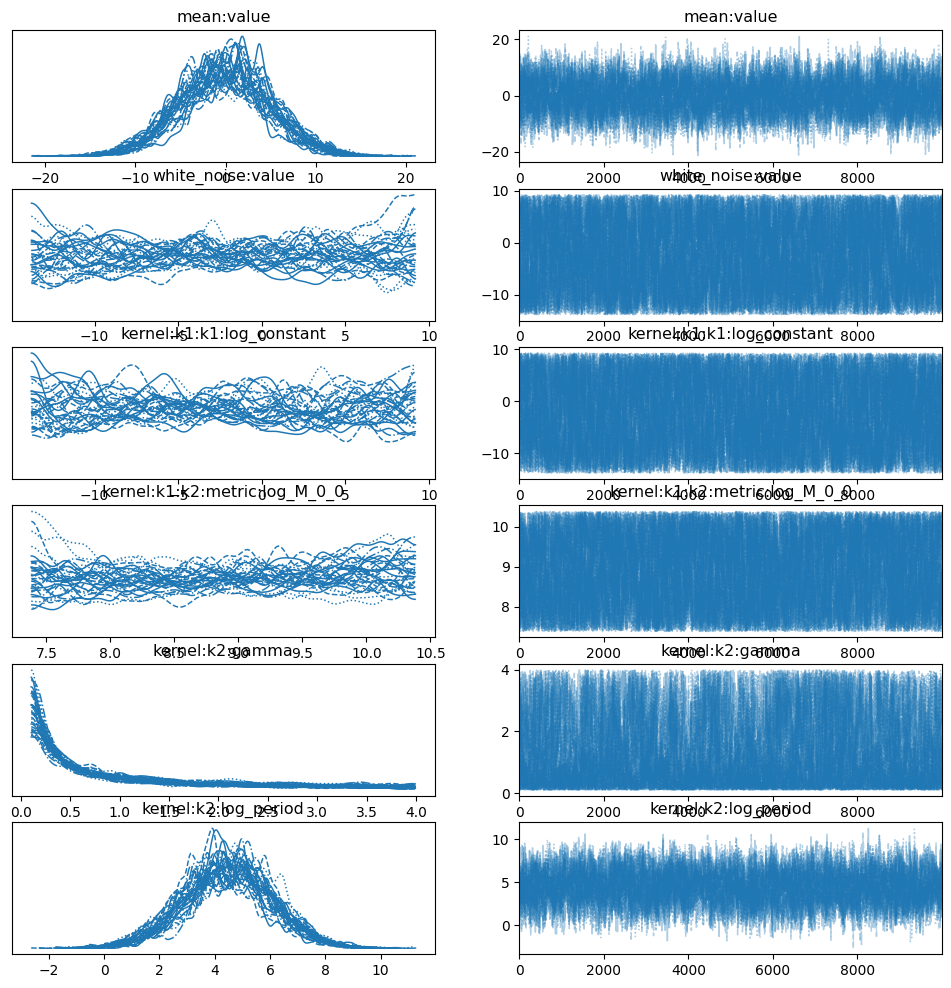

In [13]:
# Prior predictive check
nwalkers = 32
nwalkers, ndim = nwalkers, len(gp_act[instrument])
num_warmup = 200
num_prior_samples = 10_000
sampler_prior = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    log_prior,
)

p0 = sample_from_prior(nwalkers)

print(f"Running prior predictive check")
sampler_prior.run_mcmc(p0, num_prior_samples + num_warmup, progress=True)


prior_samples = sampler_prior.get_chain(discard=num_warmup)

converted_prior_samples = {
gp_act[instrument].get_parameter_names()[i]: np.swapaxes(prior_samples[..., i], 0, 1)
for i in range(len(gp_act[instrument]))}


prior_inf_data = az.from_dict(converted_prior_samples)

corner.corner(prior_inf_data)
plt.savefig(f"stars/{star}/george_radvel/activity/activity_prior_cornerplot.png")
plt.show()

az.plot_trace(prior_inf_data)
plt.savefig(f"stars/{star}/george_radvel/activity/activity_prior_traceplot.png")
plt.show()

Visualizing the prior samples

In [75]:
print('Creating prior samples...')
# Visualize prior samples
model_prior_samples = {}

for instrument in instruments: 
    num_display = 50
    maxiter = 100
    niter = 0
    model_prior_samples[instrument] = []

    while niter < maxiter and len(model_prior_samples) < num_display:
        w = np.random.randint(nwalkers)
        n = np.random.randint(num_prior_samples)
        gp_act[instrument].set_parameter_vector(prior_samples[n, w])
        try:
            model_prior_samples[instrument].append(gp_act[instrument].sample_conditional(act_data[instrument], t_mod[instrument]))
        except LinAlgError:
            print("LinAlgError")
            print(f"iteration {niter}")
            print("GP hyperparameters:")
            pprint.pprint(gp_act[instrument].get_parameter_dict())
        niter += 1
    
    model_prior_samples[instrument] = np.array(model_prior_samples[instrument])

Creating prior samples...


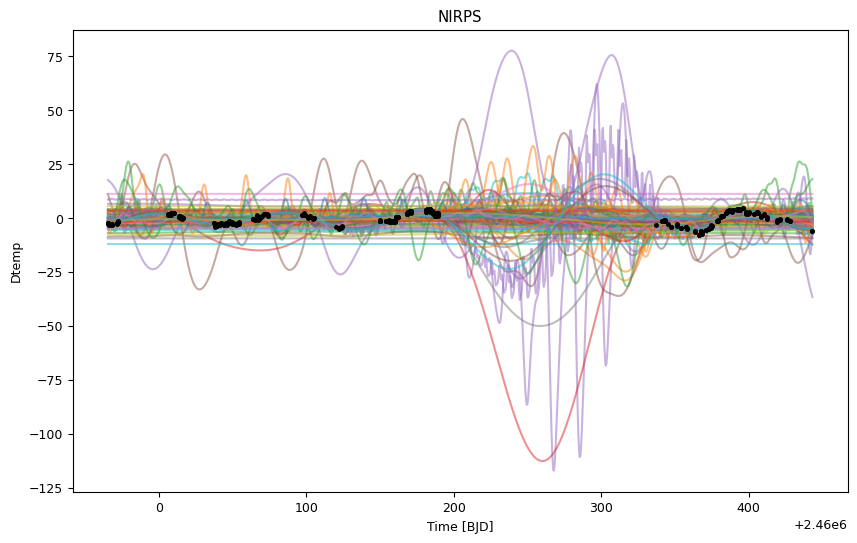

In [76]:
# Plot prior samples
fig, axes = plt.subplots(len(instruments), 1, figsize=(10, 6))

i=0
for instrument in instruments: 
    
    if len(instruments)==1: 
        axes.plot(t_mod[instrument], model_prior_samples[instrument].T, alpha=0.5)
        axes.errorbar(t_rv[instrument], act_data[instrument], yerr=act_err[instrument], fmt="k.")
        axes.set_ylabel(chosen_activity)
        axes.set_xlabel(f"Time [BJD]")
        axes.set_title(instrument)
    else: 
        axes[i].plot(t_mod[instrument], model_prior_samples[instrument].T, alpha=0.5)
        axes[i].errorbar(t_rv[instrument], act_data[instrument], yerr=act_err[instrument], fmt="k.")
        axes[i].set_ylabel(chosen_activity)
        axes[1].set_xlabel(f"Time [BJD]")
        axes[i].set_title(instrument)
    
    i+=1

plt.savefig(f"stars/{star}/george_radvel/activity/activity_prior_samples.png")
plt.show()

The prior models don't all look great, but they widely encompass the data and they do
not raise linear algebra errors.

We can now sample the posterior distribution with `emcee`. I'm using the `DEMove()` to
propose steps as it seems to help with the sampling in this case

In [14]:
# MCMC fit of the GP hyperparameters 
print('Running MCMC fit of the GP hyperparameters...')
sampler_act = {}
inf_data = {}

for instrument in instruments: 

    nwalkers, ndim = 32, len(gp_act[instrument])
    num_warmup = 600
    num_post_samples = 10_000
    sampler_act[instrument] = emcee.EnsembleSampler(
        nwalkers,
        ndim,
        log_post,
        args=(gp_act[instrument], act_data[instrument]),
        # moves=[emcee.moves.StretchMove()]
        moves=[emcee.moves.DEMove()],
    )

    # Get the guess from the previous scipy minimize fit
    gp_act[instrument].compute(t_rv[instrument], yerr=act_err[instrument])
    gp_act[instrument].set_parameter_vector(results_act[instrument].x)
    
    
    # Checking if guess is inside the prior range and if not, sample from the prior
    if not np.isfinite(log_prior(gp_act[instrument].get_parameter_vector())):
        p0 = sample_from_prior(nwalkers)
        
    else: 
        # If guess is inside the prior range, sample from a Gaussian ball around the guess
        p0 = gp_act[instrument].get_parameter_vector() + 1e-4 * np.random.randn(nwalkers, ndim)
    
    print(f"Running sampling for {instrument}")
    print(p0)
    sampler_act[instrument].run_mcmc(p0, num_post_samples + num_warmup, progress=True)
    
    
    fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    post_samples = sampler_act[instrument].get_chain(discard=num_warmup)
    labels = gp_act[instrument].get_parameter_names()
    
    for i in range(ndim):
        ax = axes[i]
        ax.plot(post_samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(post_samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number")
    plt.suptitle(instrument)
    plt.savefig(f"stars/{star}/george_radvel/activity/{instrument}_act_GP_traceplot.png")
    
    inf_data[instrument] = az.from_emcee(sampler_act[instrument], var_names=gp_act[instrument].get_parameter_names())
    inf_data[instrument] = inf_data[instrument].sel(draw=slice(num_warmup, None))
    
    inf_data[instrument].to_netcdf(f"stars/{star}/george_radvel/{instrument}_inf_data_act.nc")

Running MCMC fit of the GP hyperparameters...
Running sampling for NIRPS
[[-2.97784100e+00 -1.38044987e+01 -7.84682214e+00  8.54652294e+00
   3.45385229e+00  4.24108328e+00]
 [ 1.50672732e+00  6.58754676e+00  9.10919031e+00  9.51271989e+00
   1.03845709e+00  4.75859632e+00]
 [ 8.07944971e+00 -6.53086635e+00 -1.19749911e+01  8.93745840e+00
   2.04306686e+00  4.48185538e+00]
 [ 1.90950688e+00 -8.98062047e-01 -4.59021713e+00  9.30665411e+00
   3.98421165e+00  4.47385366e+00]
 [ 3.86024293e+00 -6.74356236e+00  3.93320491e+00  7.91112292e+00
   1.33947838e+00  4.70831557e+00]
 [ 2.25472813e+00 -1.29474713e+01  1.96124133e+00  8.61861606e+00
   1.06032652e+00  4.58115828e+00]
 [-1.64558994e+00 -1.25909220e+01 -1.10031170e+01  9.34472610e+00
   3.99896988e+00  4.41409896e+00]
 [-8.14614608e+00  2.47357865e+00  1.34104633e+00  9.01159941e+00
   2.13108736e+00  4.11857592e+00]
 [ 6.26625131e+00 -1.35254554e+01 -3.99083741e+00  1.01379645e+01
   2.02080197e+00  4.23799863e+00]
 [ 5.88650859e+00 

  0%|          | 7/10600 [00:00<16:35, 10.64it/s]

 72%|███████▏  | 7627/10600 [23:36<09:04,  5.46it/s]Traceback (most recent call last):
  File "/home/plamontagne/ongenesis/bin/miniconda3/envs/NIRPS/lib/python3.11/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_3935840/1268336263.py", line 26, in log_post
    return log_prob + gp.log_likelihood(act, quiet=True)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/plamontagne/ongenesis/bin/miniconda3/envs/NIRPS/lib/python3.11/site-packages/george/gp.py", line 385, in log_likelihood
    if not self.recompute(quiet=quiet):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/plamontagne/ongenesis/bin/miniconda3/envs/NIRPS/lib/python3.11/site-packages/george/gp.py", line 355, in recompute
    self.compute(self._x, np.sqrt(self._yerr2), **kwargs)
  File "/home/plamontagne/ongenesis/bin/miniconda3/envs/NIRPS/lib/python3.11/site-packages/george/gp.p

emcee: Exception while calling your likelihood function:
  params: [ 0.58399244 -5.42418516 -0.67004521  7.60596591  3.59946581  4.3790657 ]
  args: (<george.gp.GP object at 0x7fd757c847d0>, <Column name='d2v' dtype='float64' length=328>
  0.7889800822870362
  0.8016126615570692
  0.7858283186776435
  0.6868752262018957
  0.7432724759322457
  0.6669511689437654
  0.7616982709119465
   0.696522445326718
   0.621164279670321
   0.812605772387863
  0.8235037982604134
  0.7443713793694657
                 ...
 0.08109106642443982
-0.06639990461242909
 -0.0927235988701261
-0.09740795294178306
 0.04103631213475012
-0.05311010984284362
0.004436136245979494
-0.02774988975584783
  0.0541907828819255
-0.08736354723580231
  0.7289025704733633
  0.6751981989396864)
  kwargs: {}
  exception:


KeyboardInterrupt: 

Arviz can convert emcee posterior samples to an InferenceData object, which
facilitates summarizing, analyzing and plotting the results, and it provides
a common interface for multiple samplers. The next two lines extract samples
from emcee and remove warm-up steps.

In [78]:
# MCMC summary
for instrument in instruments: 
    print(f"Summary for {instrument} \n")
    print('--------------------------')
    print(az.summary(inf_data[instrument]))

Summary for NIRPS 

--------------------------
                                mean     sd  hdi_3%  hdi_97%  mcse_mean  \
mean:value                    -0.858  1.543  -3.755    2.014      0.080   
white_noise:value             -2.443  2.338  -7.369   -1.478      0.388   
kernel:k1:k1:log_constant      2.552  1.080   1.640    4.053      0.093   
kernel:k1:k2:metric:log_M_0_0  8.527  0.978   7.378    9.898      0.084   
kernel:k2:gamma                3.526  0.503   2.777    4.000      0.049   
kernel:k2:log_period           4.129  0.540   3.383    4.483      0.080   

                               mcse_sd  ess_bulk  ess_tail  r_hat  
mean:value                       0.085     493.0     178.0   1.06  
white_noise:value                0.277      88.0      42.0   1.27  
kernel:k1:k1:log_constant        0.102     122.0      86.0   1.23  
kernel:k1:k2:metric:log_M_0_0    0.059     110.0     144.0   1.21  
kernel:k2:gamma                  0.035     234.0     207.0   1.09  
kernel:k2:log_perio

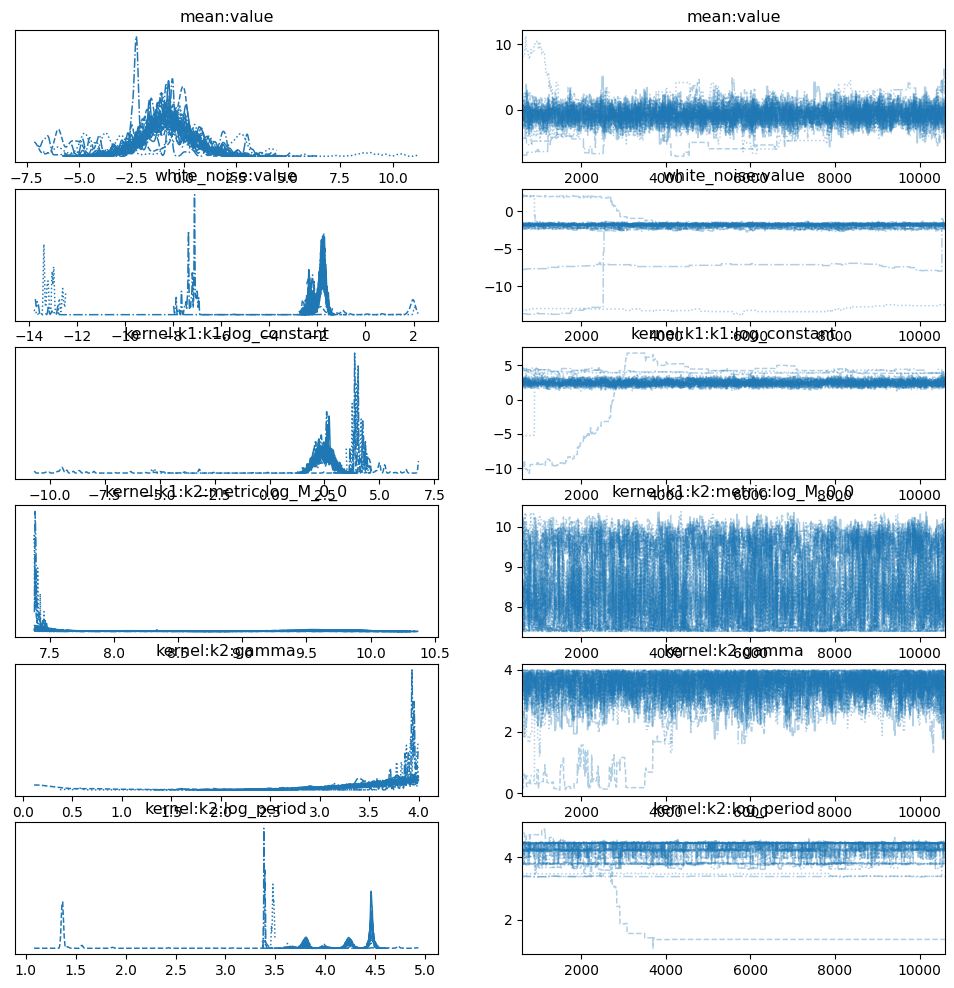

In [79]:
# Traceplots and cornerplots
for instrument in instruments: 
    az.plot_trace(inf_data[instrument])
    plt.savefig(f"stars/{star}/george_radvel/activity/{instrument}_act_GP_traceplot_2.png")
    plt.show()

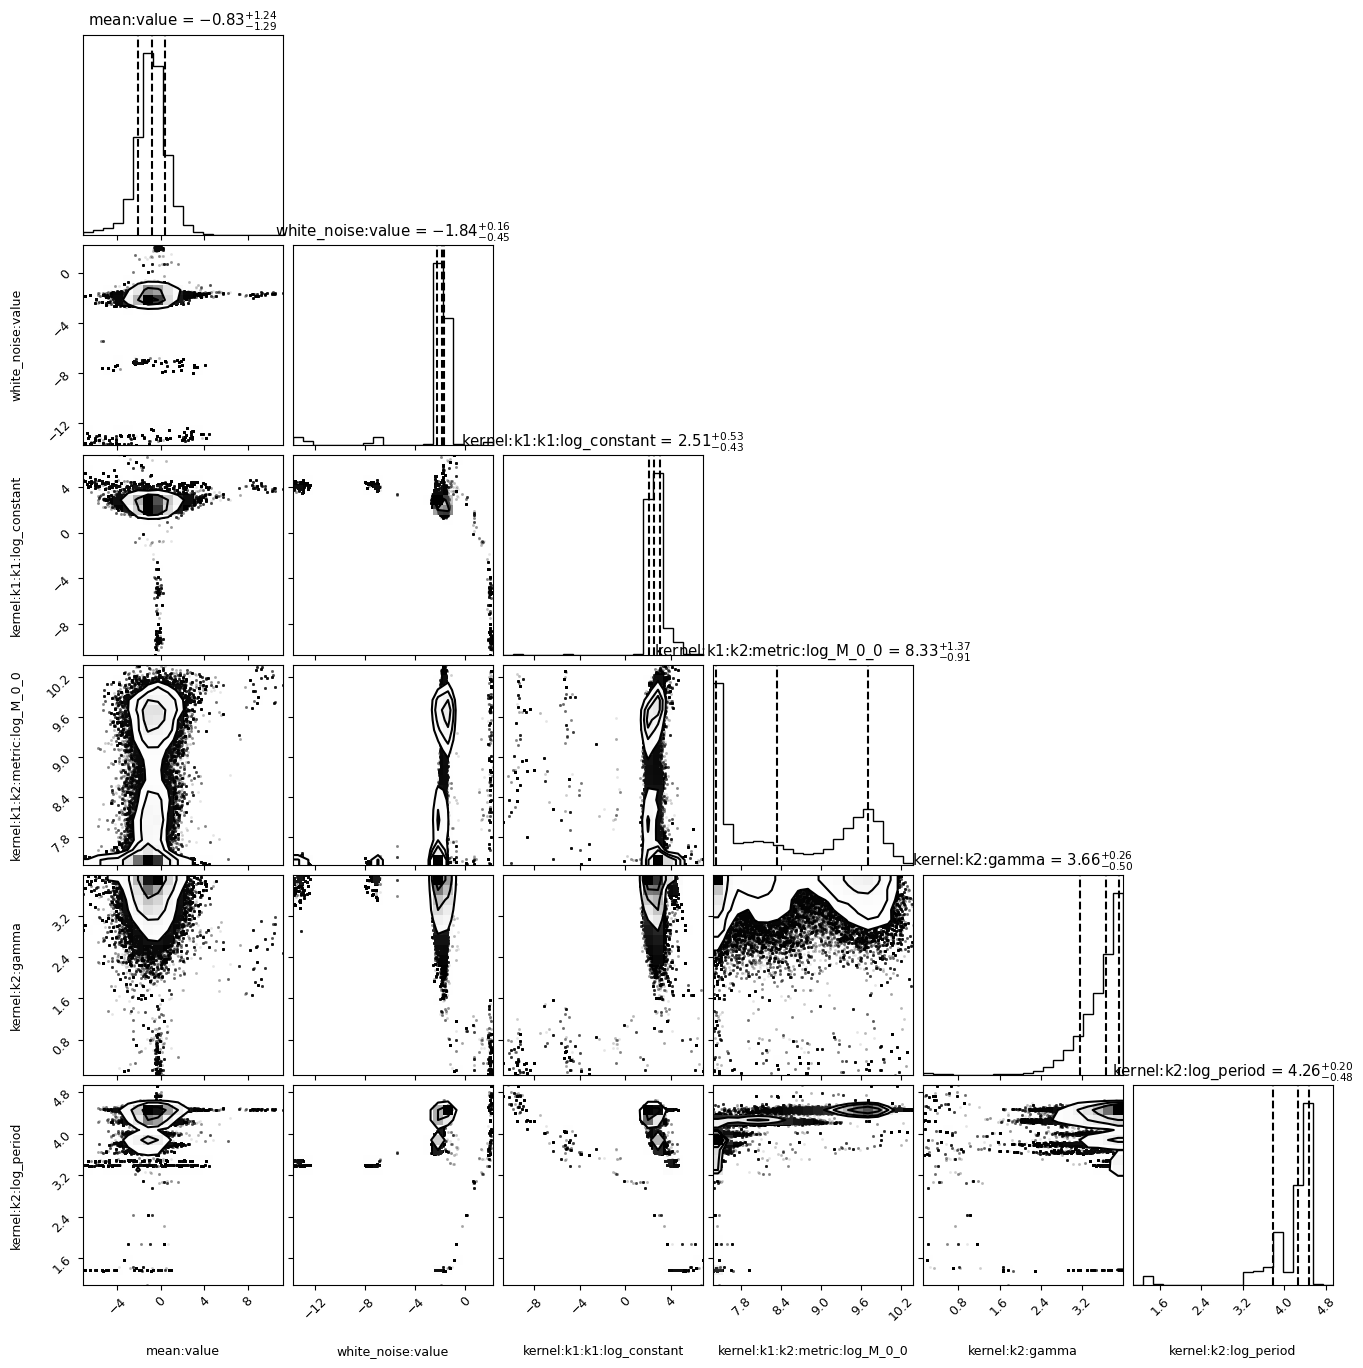

In [80]:
for instrument in instruments:
    corner.corner(inf_data[instrument], show_titles=True, quantiles=[0.16, 0.5, 0.84])
    plt.savefig(f"stars/{star}/george_radvel/activity/{instrument}_act_GP_cornerplot.png")

In [81]:
# Visualize posterior samples and max/median likelihood models
print('Creating posterior samples...')
model_post_samples = {}

for instrument in instruments: 
    num_display = 50
    maxiter = 100
    niter = 0
    model_post_samples[instrument] = []

    while niter < maxiter and len(model_post_samples[instrument]) < num_display:
        w = np.random.randint(nwalkers)
        n = np.random.randint(num_post_samples)
        gp_act[instrument].set_parameter_vector(post_samples[n, w])
        try:
            model_post_samples[instrument].append(gp_act[instrument].sample_conditional(act_data[instrument], t_mod[instrument]))
        except LinAlgError:
            print("LinAlgError")
            print(f"iteration {niter}")
            print("GP hyperparameters:")
            pprint.pprint(gp_act[instrument].get_parameter_dict())
        niter += 1
        
    model_post_samples[instrument] = np.array(model_post_samples[instrument])

Creating posterior samples...


In [82]:
# Maximum/Median likelihood parameters
max_likelihood_params = {}
median_likelihood_params = {}

for instrument in instruments: 
    max_likelihood_params[instrument] = inf_data[instrument].posterior.max().to_array().values
    median_likelihood_params[instrument] = inf_data[instrument].posterior.median().to_array().values
    
    print(f"Median likelihood parameters for {instrument}")
    print('--------------------------')
    print(median_likelihood_params[instrument])
    
    print(f"Maximum likelihood parameters for {instrument}")
    print('--------------------------')
    print(max_likelihood_params[instrument])

Median likelihood parameters for NIRPS
--------------------------
[-0.83172623 -1.84123607  2.5102612   8.33297914  3.66131017  4.26408441]
Maximum likelihood parameters for NIRPS
--------------------------
[11.2508089   2.20421315  6.79255799 10.37578275  3.99992805  4.93714611]


The period of the star predicted by Dtemp is 71.10 days for NIRPS
The period of the star predicted by Dtemp is 71.10 days


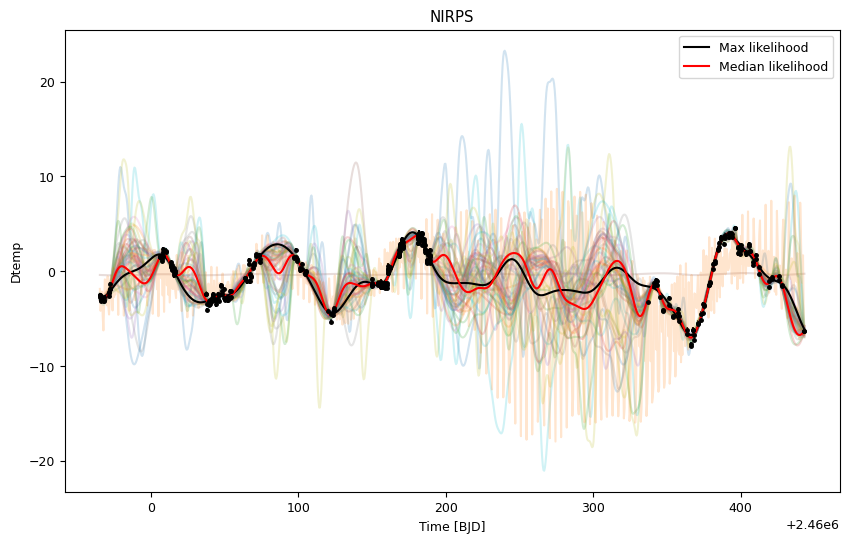

In [83]:
# Plotting
fig, axes = plt.subplots(len(instruments), 1, figsize=(10, 6), sharex=True)

i=0
for instrument in instruments: 
    # Maximum likelihood parameters
    gp_act[instrument].set_parameter_vector(max_likelihood_params[instrument])
    mu_max, var_max = gp_act[instrument].predict(act_data[instrument], t_mod[instrument], return_var=True)
    
    # Median likelihood parameters
    gp_act[instrument].set_parameter_vector(median_likelihood_params[instrument])
    mu_med, var_med = gp_act[instrument].predict(act_data[instrument], t_mod[instrument], return_var=True)
    #std = np.sqrt(var)
    
    if len(instruments)==1: 
        axes.errorbar(t_rv[instrument], act_data[instrument], yerr=act_err[instrument], fmt="k.")
        axes.plot(t_mod[instrument], model_post_samples[instrument].T, alpha=0.2)
        axes.plot(t_mod[instrument], mu_max, color='black', label='Max likelihood')
        axes.plot(t_mod[instrument], mu_med, color='red', label='Median likelihood')
        #axes.fill_between(t_mod[instrument], mu - std, mu + std, alpha=0.2, color="C0")
        axes.set_title(instrument)
        axes.set_ylabel("Dtemp")
        axes.set_xlabel(f"Time [BJD]")

    else:
        axes[i].errorbar(t_rv[instrument], act_data[instrument], yerr=act_err[instrument], fmt="k.")
        axes[i].plot(t_mod[instrument], model_post_samples[instrument].T, alpha=0.2)
        axes[i].plot(t_mod[instrument], mu_max, color='black', label='Max likelihood')
        axes[i].plot(t_mod[instrument], mu_med, color='red', label='Median likelihood')
        #axes[i].fill_between(t_mod[instrument], mu - std, mu + std, alpha=0.2, color="C0")
        axes[i].set_title(instrument)
        axes[i].set_ylabel(chosen_activity)
        axes[1].set_xlabel(f"Time [BJD]")
    
    print(f'The period of the star predicted by {act_label} is {np.exp(gp_act[instrument].get_parameter_dict()["kernel:k2:log_period"]):.2f} days for {instrument}')
    
    i+=1

plt.legend()
plt.savefig(f"stars/{star}/george_radvel/activity/{activity_priors['chosen_activity']}_GP_MC_fit.png")

    
print(f'The period of the star predicted by {act_label} is {np.exp(gp_act[instrument].get_parameter_dict()["kernel:k2:log_period"]):.2f} days')

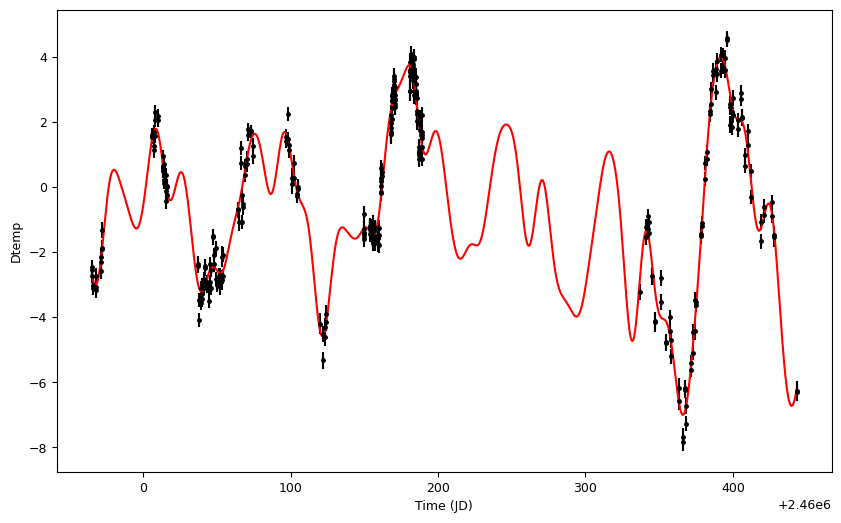

In [84]:
# Plot only the median likelihood model
fig, axes = plt.subplots(len(instruments), 1, figsize=(10, 6), sharex=True)

for instrument in instruments: 
    plt.errorbar(t_rv[instrument], act_data[instrument], yerr=act_err[instrument], fmt="k.")
    plt.plot(t_mod[instrument], mu_med, color='red', label='Median likelihood')
    plt.xlabel('Time (JD)')
    plt.ylabel(chosen_activity)

    plt.show()
    
    

If the fit doesn't look great, here are a few ideas to explore:
- Try another sampler (nested sampling, No-U-Turn-Sampling with PyMC+exoplanet, etc.)
- Explore emcee options (e.g. Moves) to see if it improves the sampling
- Explore if other priors yield better/different results.
- Try another kernel, either by changing the structure of your george model above or
  by using celerite, celerite2, tinygp or another package.
  - Celerite almost has the same interface as george, but supports a specific class
    of kernels which provide more efficient calculation. Most kernels there are quasi-periodic which
    is great for our use-case.
  - `tinygp` and `celerite2` can be seen as more modern versions of `george` and `celerite`.
    They support autodifferentiation frameworks (gradients "for free"!).

## RV Modelling
Now that we have a model for the activity, we can use this as prior knowledge for the
RV modelling.

As mentioned above, we will use RadVel in this section: it is well tested, provides
a simple interface, and supports GPs out of the box.

The flexibility of the RadVel GP models is somewhat limited, but new kernels can
technically be added by implementing custom classes.

In [85]:
pprint.pprint(radvel.gp.KERNELS)

{'Celerite': ['gp_B', 'gp_C', 'gp_L', 'gp_Prot'],
 'Per': ['gp_per', 'gp_length', 'gp_amp'],
 'QuasiPer': ['gp_per', 'gp_perlength', 'gp_explength', 'gp_amp'],
 'SqExp': ['gp_length', 'gp_amp']}


### Converting samples from the activity model
The activity model we used above used the default George parametrization.
In practice we would probably want to implement GP kernels with the same
parameterization for activity indicators and RV. However, we can still
use our activity model as a prior by converting posterior samples.

The equation for the RadVel QP kernel can be found [in the docs](https://radvel.readthedocs.io/en/latest/gp.html).
The same is true for [george kernels](https://george.readthedocs.io/en/latest/user/kernels/).
From the equations there, we can derive posteriors corresponding to RadVel parameters. This
is simple with Arviz InferenceData

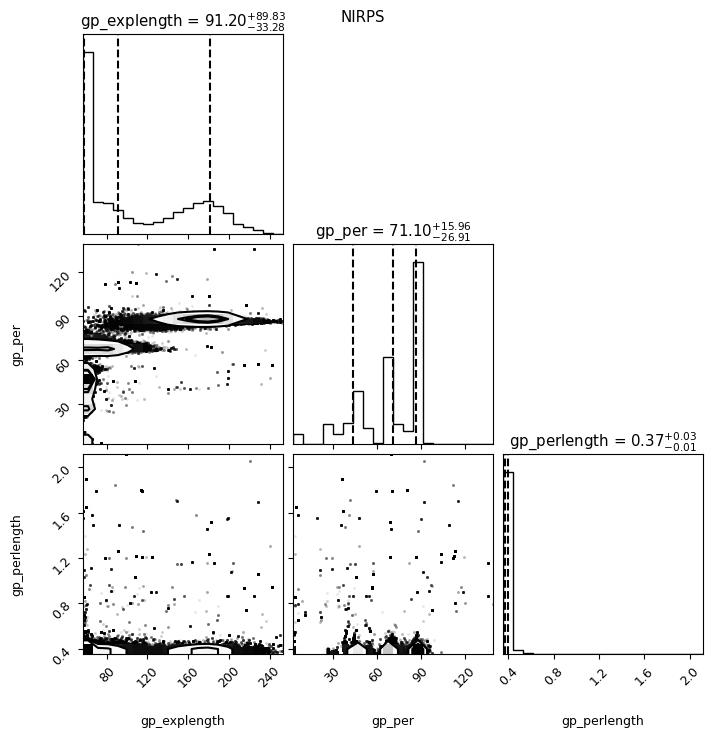

In [86]:
################# RADVEL PART #######################
# We need to declare parameters for our GP likelihood a few cells below

inf_post = {}
for instrument in instruments: 
    inf_post[instrument] = inf_data[instrument].posterior
    inf_post[instrument]["gp_explength"] = np.sqrt(2*np.exp(inf_post[instrument]["kernel:k1:k2:metric:log_M_0_0"]))
    inf_post[instrument]["gp_per"] = np.exp(inf_post[instrument]["kernel:k2:log_period"])
    inf_post[instrument]["gp_perlength"] = np.sqrt(0.5 / inf_post[instrument]["kernel:k2:gamma"])

for instrument in instruments:
    corner.corner(
        inf_data[instrument],
        var_names=["gp_explength", "gp_per", "gp_perlength"],
        show_titles=True,
        quantiles=[0.16, 0.5, 0.84],
    )
    plt.suptitle(instrument)
    plt.savefig(f"stars/{star}/george_radvel/RV/{instrument}_post_to_prior_cornerplot.png")


### Defining the RV model
A RadVel model contains the following components:
- A set of parameters
- A `Model` object defining the forward model
- A `Likelihood` object (chi2 or GP)
- A `Posterior`, which combines the likelihood with priors.

Let us start by initializing the parameters

Planet related parameters

In [87]:
# Let us start by initializing the parameters
print('Initializing RadVel model...')
instrument = RV_priors['chosen_instrument'] #The instrument we trust the most to lead the GP fit... TODO: Can be changed

# The basis determines the orbit parametrization
params = radvel.Parameters(RV_priors['nplanets'], basis="per tc secosw sesinw k")

# Orbit parameters
params["per1"] = radvel.Parameter(value=RV_priors['per1']['guess'], vary=True)
params["tc1"] = radvel.Parameter(value=RV_priors['tc1']['guess'], vary=True)
params["sesinw1"] = radvel.Parameter(value=RV_priors['sesinw1']['guess'], vary=False)  # fix e = 0 for now
params["secosw1"] = radvel.Parameter(value=RV_priors['secosw1']['guess'], vary=False)
params["k1"] = radvel.Parameter(value=RV_priors['k1']['guess'], vary=True)

if RV_priors['nplanets'] == 2 :
    params["per2"] = radvel.Parameter(value=RV_priors['per2']['guess'], vary=True)
    params["tc2"] = radvel.Parameter(value=RV_priors['tc2']['guess'], vary=True)
    params["sesinw2"] = radvel.Parameter(value=RV_priors['sesinw2']['guess'], vary=False)  # fix e = 0 for now
    params["secosw2"] = radvel.Parameter(value=RV_priors['secosw2']['guess'], vary=False)
    params["k2"] = radvel.Parameter(value=RV_priors['k2']['guess'], vary=True)


Initializing RadVel model...


GP related parameters

In [88]:
# GP parameters
params["gp_amp"] = radvel.Parameter(value=RV_priors['GP_sigma']['guess'], vary=True)

if RV_priors['use_indicator']: 
    # Length scale, period and gamma parameters are derived from activity indicator
    params["gp_explength"] = radvel.Parameter(
        value=inf_post[instrument].quantile(0.5)["gp_explength"].item()
    )
    params["gp_per"] = radvel.Parameter(value=inf_post[instrument].quantile(0.5)["gp_per"].item())
    params["gp_perlength"] = radvel.Parameter(
        value=inf_post[instrument].quantile(0.5)["gp_perlength"].item()
    )
    
else: 
    # Length scale, period and gamma parameters are derived from the RVs
    params["gp_explength"] = radvel.Parameter(value=np.sqrt(2)*RV_priors['GP_length']['guess'])
    params["gp_per"] = radvel.Parameter(value=RV_priors['GP_Prot']['guess'])
    params["gp_perlength"] = radvel.Parameter(value=np.sqrt(0.5/RV_priors['GP_gamma']['guess']))

trend and quadratic variations

In [89]:
# The RV model is built from the parameters, but adds
# a trend and a quadratic variation to the model. We fix  them to 0.
mod = radvel.RVModel(params)
mod.params["dvdt"] = radvel.Parameter(value=0.0, vary=False)
mod.params["curv"] = radvel.Parameter(value=0.0, vary=False)

When the model includes GPs, we use `GPLikelihood` instead of `Likelhood`.
Here we combine the model, the data, and the GP info.

The "jit" parameter is a white noise term. Gamma is the RV offset.

In [90]:
# Combine RV data from different instruments into a single dataframe
# Select instruments to the fit on:
CCF = False

y_rv_all = np.concatenate([y_rv[instrument] for instrument in instruments])
yerr_rv_all = np.concatenate([yerr_rv[instrument] for instrument in instruments])
t_rv_all = np.concatenate([t_rv[instrument] for instrument in instruments])

if t_ccf: 
    y_rv_all_ccf = np.concatenate([y_rv_ccf[instrument] for instrument in instruments_ccf])
    yerr_rv_all_ccf = np.concatenate([yerr_rv_ccf[instrument] for instrument in instruments_ccf])
    t_rv_all_ccf = np.concatenate([t_ccf[instrument] for instrument in instruments_ccf])

In [91]:
if CCF: 
    like = radvel.likelihood.GPLikelihood(
        mod, t_rv_all_ccf, y_rv_all_ccf, yerr_rv_all_ccf, hnames, kernel_name="QuasiPer"
    )

else: 
    like = radvel.likelihood.GPLikelihood(
        mod, t_rv_all, y_rv_all, yerr_rv_all, hnames, kernel_name="QuasiPer"
    )
    
like.params["gamma"] = radvel.Parameter(value=RV_priors['mu']['guess'], vary=True)
like.params["jit"] = radvel.Parameter(value=RV_priors['noise']['guess'], vary=True)

We can now create a posterior object from the likelihood and combine
it with priors.

For orbit parameters, we use weakly informative priors.
For the GP length scales, however, we use gaussian distributions
derived from the activity posteriors.
Note that this is not ideal: we would want a more flexibile distribution
in to capture non-gaussianity. The extreme case of this is to use a kernel
density estimate as the prior (`NumericalPrior` in radvel). However this is
a bit more computationally expensive and, in our case, there was a strong
bimodality in the period posterior, which we might not want to force on the RV fit.

In [92]:
post = radvel.posterior.Posterior(like)

In [93]:
# Period of the planet
if RV_priors['per1']['distribution'] == 'Uniform':
    post.priors += [radvel.prior.HardBounds("per1", RV_priors['per1']['min'], RV_priors['per1']['max'])]
elif RV_priors['per1']['distribution'] == 'loguniform':
    post.priors += [radvel.prior.Jeffreys("per1", RV_priors['per1']['min'], RV_priors['per1']['max'])]
elif RV_priors['per1']['distribution'] == 'Normal':
    post.priors += [radvel.prior.Gaussian("per1", RV_priors['per1']['mean'], RV_priors['per1']['std'])]
else: 
    raise ValueError('Distribution not recognized for period of the planet')

# Time of transit
if RV_priors['tc1']['distribution'] == 'Uniform':
    post.priors += [radvel.prior.HardBounds("tc1", RV_priors['tc1']['min'], RV_priors['tc1']['max'])]
elif RV_priors['tc1']['distribution'] == 'loguniform':
    post.priors += [radvel.prior.Jeffreys("tc1", RV_priors['tc1']['min'], RV_priors['tc1']['max'])]
elif RV_priors['tc1']['distribution'] == 'Normal':
    post.priors += [radvel.prior.Gaussian("tc1", RV_priors['tc1']['mean'], RV_priors['tc1']['std'])]
else: 
    raise ValueError('Distribution not recognized for time of transit')

# Semi-amplitude of the planet signal
if RV_priors['k1']['distribution'] == 'Uniform':
    post.priors += [radvel.prior.HardBounds("k1", RV_priors['k1']['min'], RV_priors['k1']['max'])]
elif RV_priors['k1']['distribution'] == 'loguniform':
    post.priors += [radvel.prior.Jeffreys("k1", RV_priors['k1']['min'], RV_priors['k1']['max'])]
elif RV_priors['k1']['distribution'] == 'Normal':
    post.priors += [radvel.prior.Gaussian("k1", RV_priors['k1']['mean'], RV_priors['k1']['std'])]
else:
    raise ValueError('Distribution not recognized for semi-amplitude of the planet signal')

if RV_priors['nplanets'] == 2: 
    # Period of the planet
    if RV_priors['per2']['distribution'] == 'Uniform':
        post.priors += [radvel.prior.HardBounds("per2", RV_priors['per2']['min'], RV_priors['per2']['max'])]
    elif RV_priors['per2']['distribution'] == 'loguniform':
        post.priors += [radvel.prior.Jeffreys("per2", RV_priors['per2']['min'], RV_priors['per2']['max'])]
    elif RV_priors['per2']['distribution'] == 'Normal':
        post.priors += [radvel.prior.Gaussian("per2", RV_priors['per2']['mean'], RV_priors['per2']['std'])]
    elif RV_priors['per2']['distribution'] == 'fixed':
        post.priors += [radvel.prior.Gaussian("per2", RV_priors['per2']['guess'], 1e-10)]
    else: 
        raise ValueError('Distribution not recognized for period of the second planet')

    # Time of transit
    if RV_priors['tc2']['distribution'] == 'Uniform':
        post.priors += [radvel.prior.HardBounds("tc2", RV_priors['tc2']['min'], RV_priors['tc2']['max'])]
    elif RV_priors['tc2']['distribution'] == 'loguniform':
        post.priors += [radvel.prior.Jeffreys("tc2", RV_priors['tc2']['min'], RV_priors['tc2']['max'])]
    elif RV_priors['tc2']['distribution'] == 'Normal':
        post.priors += [radvel.prior.Gaussian("tc2", RV_priors['tc2']['mean'], RV_priors['tc2']['std'])]
    elif RV_priors['tc2']['distribution'] == 'fixed':
        post.priors += [radvel.prior.Gaussian("tc2", RV_priors['tc2']['guess'], 1e-10)]
    else: 
        raise ValueError('Distribution not recognized for the second time of transit')

    # Semi-amplitude of the planet signal
    if RV_priors['k2']['distribution'] == 'Uniform':
        post.priors += [radvel.prior.HardBounds("k2", RV_priors['k2']['min'], RV_priors['k2']['max'])]
    elif RV_priors['k2']['distribution'] == 'loguniform':
        post.priors += [radvel.prior.Jeffreys("k2", RV_priors['k2']['min'], RV_priors['k2']['max'])]
    elif RV_priors['k2']['distribution'] == 'Normal':
        post.priors += [radvel.prior.Gaussian("k2", RV_priors['k2']['mean'], RV_priors['k2']['std'])]
    else:
        raise ValueError('Distribution not recognized for semi-amplitude of the second planet signal')



# GP parameters
# RV offset
if RV_priors['mu']['distribution'] == 'Uniform':
    post.priors += [radvel.prior.HardBounds("gamma", RV_priors['mu']['min'], RV_priors['mu']['max'])]
elif RV_priors['mu']['distribution'] == 'loguniform':
    post.priors += [radvel.prior.Jeffreys("gamma", RV_priors['mu']['min'], RV_priors['mu']['max'])]
elif RV_priors['mu']['distribution'] == 'Normal':
    post.priors += [radvel.prior.Gaussian("gamma", RV_priors['mu']['mean'], RV_priors['mu']['std'])]
else:
    raise ValueError('Distribution not recognized for sub-structures')

# Amplitude of the GP
if RV_priors['GP_sigma']['distribution'] == 'Uniform':
    post.priors += [radvel.prior.HardBounds("gp_amp", RV_priors['GP_sigma']['min'], RV_priors['GP_sigma']['max'])]
elif RV_priors['GP_sigma']['distribution'] == 'loguniform':
    post.priors += [radvel.prior.Jeffreys("gp_amp", RV_priors['GP_sigma']['min'], RV_priors['GP_sigma']['max'])]
elif RV_priors['GP_sigma']['distribution'] == 'Normal':
    post.priors += [radvel.prior.Gaussian("gp_amp", RV_priors['GP_sigma']['mean'], RV_priors['GP_sigma']['std'])]
elif RV_priors['GP_sigma']['distribution'] == 'fixed':
    post.priors += [radvel.prior.Gaussian("gp_amp", RV_priors['GP_sigma']['guess'], 1e-10)]
else:
    raise ValueError('Distribution not recognized for amplitude of the GP')

# White noise
if RV_priors['noise']['distribution'] == 'Uniform':
    post.priors += [radvel.prior.HardBounds("jit", RV_priors['noise']['min'], RV_priors['noise']['max'])]
elif RV_priors['noise']['distribution'] == 'loguniform':
    post.priors += [radvel.prior.Jeffreys("jit", RV_priors['noise']['min'], RV_priors['noise']['max'])]
elif RV_priors['noise']['distribution'] == 'Normal':
    post.priors += [radvel.prior.Gaussian("jit", RV_priors['noise']['mean'], RV_priors['noise']['std'])]
else:
    raise ValueError('Distribution not recognized for white noise')




if RV_priors['use_indicator']: 
    # Gaussian around the length scale, period and gamma found from the activity indicator
    derived_unc = np.mean(np.abs(inf_post[instrument].quantile([0.16, 0.84]) - inf_post[instrument].quantile(0.5)))
    post.priors += [
        radvel.prior.Gaussian(
            "gp_explength",
            inf_post[instrument].quantile(0.5)["gp_explength"].item(),
            derived_unc["gp_explength"],
        )
    ]
    post.priors += [
        radvel.prior.Gaussian(
            "gp_per", inf_post[instrument].quantile(0.5)["gp_per"].item(), derived_unc["gp_per"]
        )
    ]
    # post.priors += [
    #     radvel.prior.NumericalPrior(
    #         "gp_per", inf_post.quantile(0.5)["gp_per"].item(), derived_unc["gp_per"]
    #     )
    # ]
    post.priors += [
        radvel.prior.Gaussian(
            "gp_perlength",
            inf_post[instrument].quantile(0.5)["gp_perlength"].item(),
            derived_unc["gp_perlength"],
        )
    ]
    
else: 
    # Period of the GP
    if RV_priors['GP_Prot']['distribution'] == 'Uniform':
        post.priors += [radvel.prior.HardBounds("gp_per", RV_priors['GP_Prot']['min'], RV_priors['GP_Prot']['max'])]
    elif RV_priors['GP_Prot']['distribution'] == 'loguniform':
        post.priors += [radvel.prior.Jeffreys("gp_per", RV_priors['GP_Prot']['min'], RV_priors['GP_Prot']['max'])]
    elif RV_priors['GP_Prot']['distribution'] == 'Normal':
        post.priors += [radvel.prior.Gaussian("gp_per", RV_priors['GP_Prot']['mean'], RV_priors['GP_Prot']['std'])]
    else:
        raise ValueError('Distribution not recognized for GP period')
    
    # Length scale of the GP
    if RV_priors['GP_length']['distribution'] == 'Uniform':
        post.priors += [radvel.prior.HardBounds("gp_explength", np.sqrt(2)*RV_priors['GP_length']['min'], np.sqrt(2)*RV_priors['GP_length']['max'])]
    elif RV_priors['GP_length']['distribution'] == 'loguniform':
        post.priors += [radvel.prior.Jeffreys("gp_explength", np.sqrt(2)*RV_priors['GP_length']['min'], np.sqrt(2)*RV_priors['GP_length']['max'])]
    elif RV_priors['GP_length']['distribution'] == 'Normal':
        post.priors += [radvel.prior.Gaussian("gp_explength", np.sqrt(2)*RV_priors['GP_length']['mean'], np.sqrt(2)*RV_priors['GP_length']['std'])]
    else:
        raise ValueError('Distribution not recognized for GP length scale')
    
    # Gamma of the GP
    if RV_priors['GP_gamma']['distribution'] == 'Uniform':
        post.priors += [radvel.prior.HardBounds("gp_perlength", np.sqrt(0.5/RV_priors['GP_gamma']['min']), np.sqrt(0.5/RV_priors['GP_gamma']['max']))]
    elif RV_priors['GP_gamma']['distribution'] == 'loguniform':
        post.priors += [radvel.prior.Jeffreys("gp_perlength", np.sqrt(0.5/RV_priors['GP_gamma']['max']), np.sqrt(0.5/RV_priors['GP_gamma']['min']))]
    elif RV_priors['GP_gamma']['distribution'] == 'Normal':
        post.priors += [radvel.prior.Gaussian("gp_perlength", np.sqrt(0.5/RV_priors['GP_gamma']['mean']), (1/(4*RV_priors['GP_gamma']['mean']**(-2)))*(1/(2*RV_priors['GP_gamma']['mean']))**(-1/2)*RV_priors['GP_gamma']['std'])]
    else:
        raise ValueError('Distribution not recognized for GP gamma')

In [94]:
print(post)

parameter                     value      vary
per1                        11.1868       True
tc1                             202       True
secosw1                           0      False
sesinw1                           0      False
k1                              1.3       True
per2                        11.1868       True
tc2                             202       True
secosw2                           0      False
sesinw2                           0      False
k2                              1.3       True
gp_amp                            3       True
gp_explength                91.2008       True
gp_per                      71.0998       True
gp_perlength               0.369544       True
dvdt                              0      False
curv                              0      False
gamma                             0       True
jit                               1       True
tp1                         199.203           
e1                                0           
w1            

In [95]:
print("Minimizing negative loglikelihood...")
res = op.minimize(
    post.neglogprob_array,
    post.get_vary_params(),
    method="Powell",
    options=dict(maxiter=200, maxfev=100000, xatol=1e-8)
)
print('Results:')

print('--------------------------\n')
print(res)

Minimizing negative loglikelihood...


Results:
--------------------------

 message: Maximum number of iterations has been exceeded.
 success: False
  status: 2
     fun: inf
       x: [ 5.288e+02  7.196e+02  5.189e+02  5.288e+02  7.196e+02
            5.189e+02  5.206e+02  6.088e+02  5.887e+02  5.180e+02
            5.176e+02  5.186e+02]
     nit: 200
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 26600


In [96]:
post.set_vary_params(res.x)
print(post)

parameter                     value      vary
per1                        528.773       True
tc1                         719.586       True
secosw1                           0      False
sesinw1                           0      False
k1                          518.886       True
per2                        528.773       True
tc2                         719.586       True
secosw2                           0      False
sesinw2                           0      False
k2                          518.886       True
gp_amp                      520.586       True
gp_explength                608.787       True
gp_per                      588.686       True
gp_perlength                517.955       True
dvdt                              0      False
curv                              0      False
gamma                       517.586       True
jit                         518.586       True
tp1                         587.393           
e1                                0           
w1            

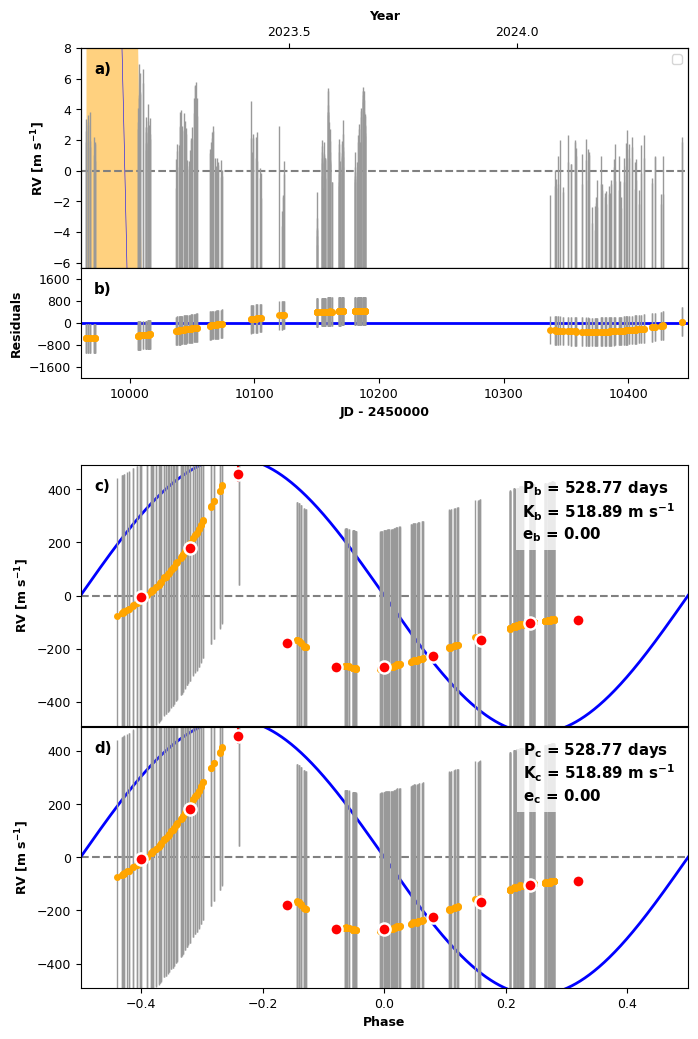

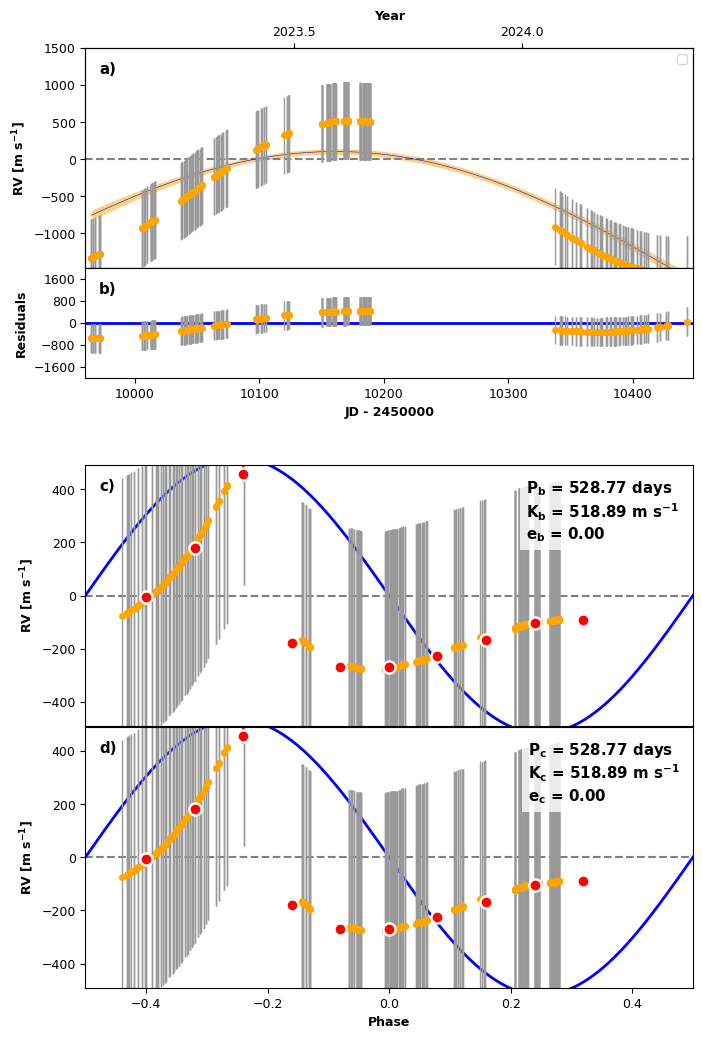

In [97]:
GPPlot = orbit_plots.GPMultipanelPlot(
    post,
    subtract_gp_mean_model=False,
    plot_likelihoods_separately=False,
    subtract_orbit_model=False,
)
GPPlot.plot_multipanel()
plt.show()

GPPlot = orbit_plots.GPMultipanelPlot(
    post,
    subtract_gp_mean_model=False,
    plot_likelihoods_separately=False,
    subtract_orbit_model=True,
)
GPPlot.plot_multipanel()
plt.show()


### Parameter Optimization
That's it! We have a working RadVel model.
We can plot the model with its initial parameter values below.
Then we will optimize the model with scipy and plot the updated result.

In [98]:
print("Running MCMC for 1 planet + GP model...")

chains = radvel.mcmc(
    post, nwalkers=32, nrun=1000, ensembles=4, savename="rawchains.h5"
)

chains.to_csv(f"stars/{star}/george_radvel/1_planet+GP_radvel_chains.csv")

Running MCMC for 1 planet + GP model...


128000/128000 (100.0%) steps complete; Running 613.54 steps/s; Mean acceptance rate = 0.0%; Min Auto Factor =  10; Max Auto Relative-Change = 0.053; Min Tz = 132.7; Max G-R = 1.049

MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.


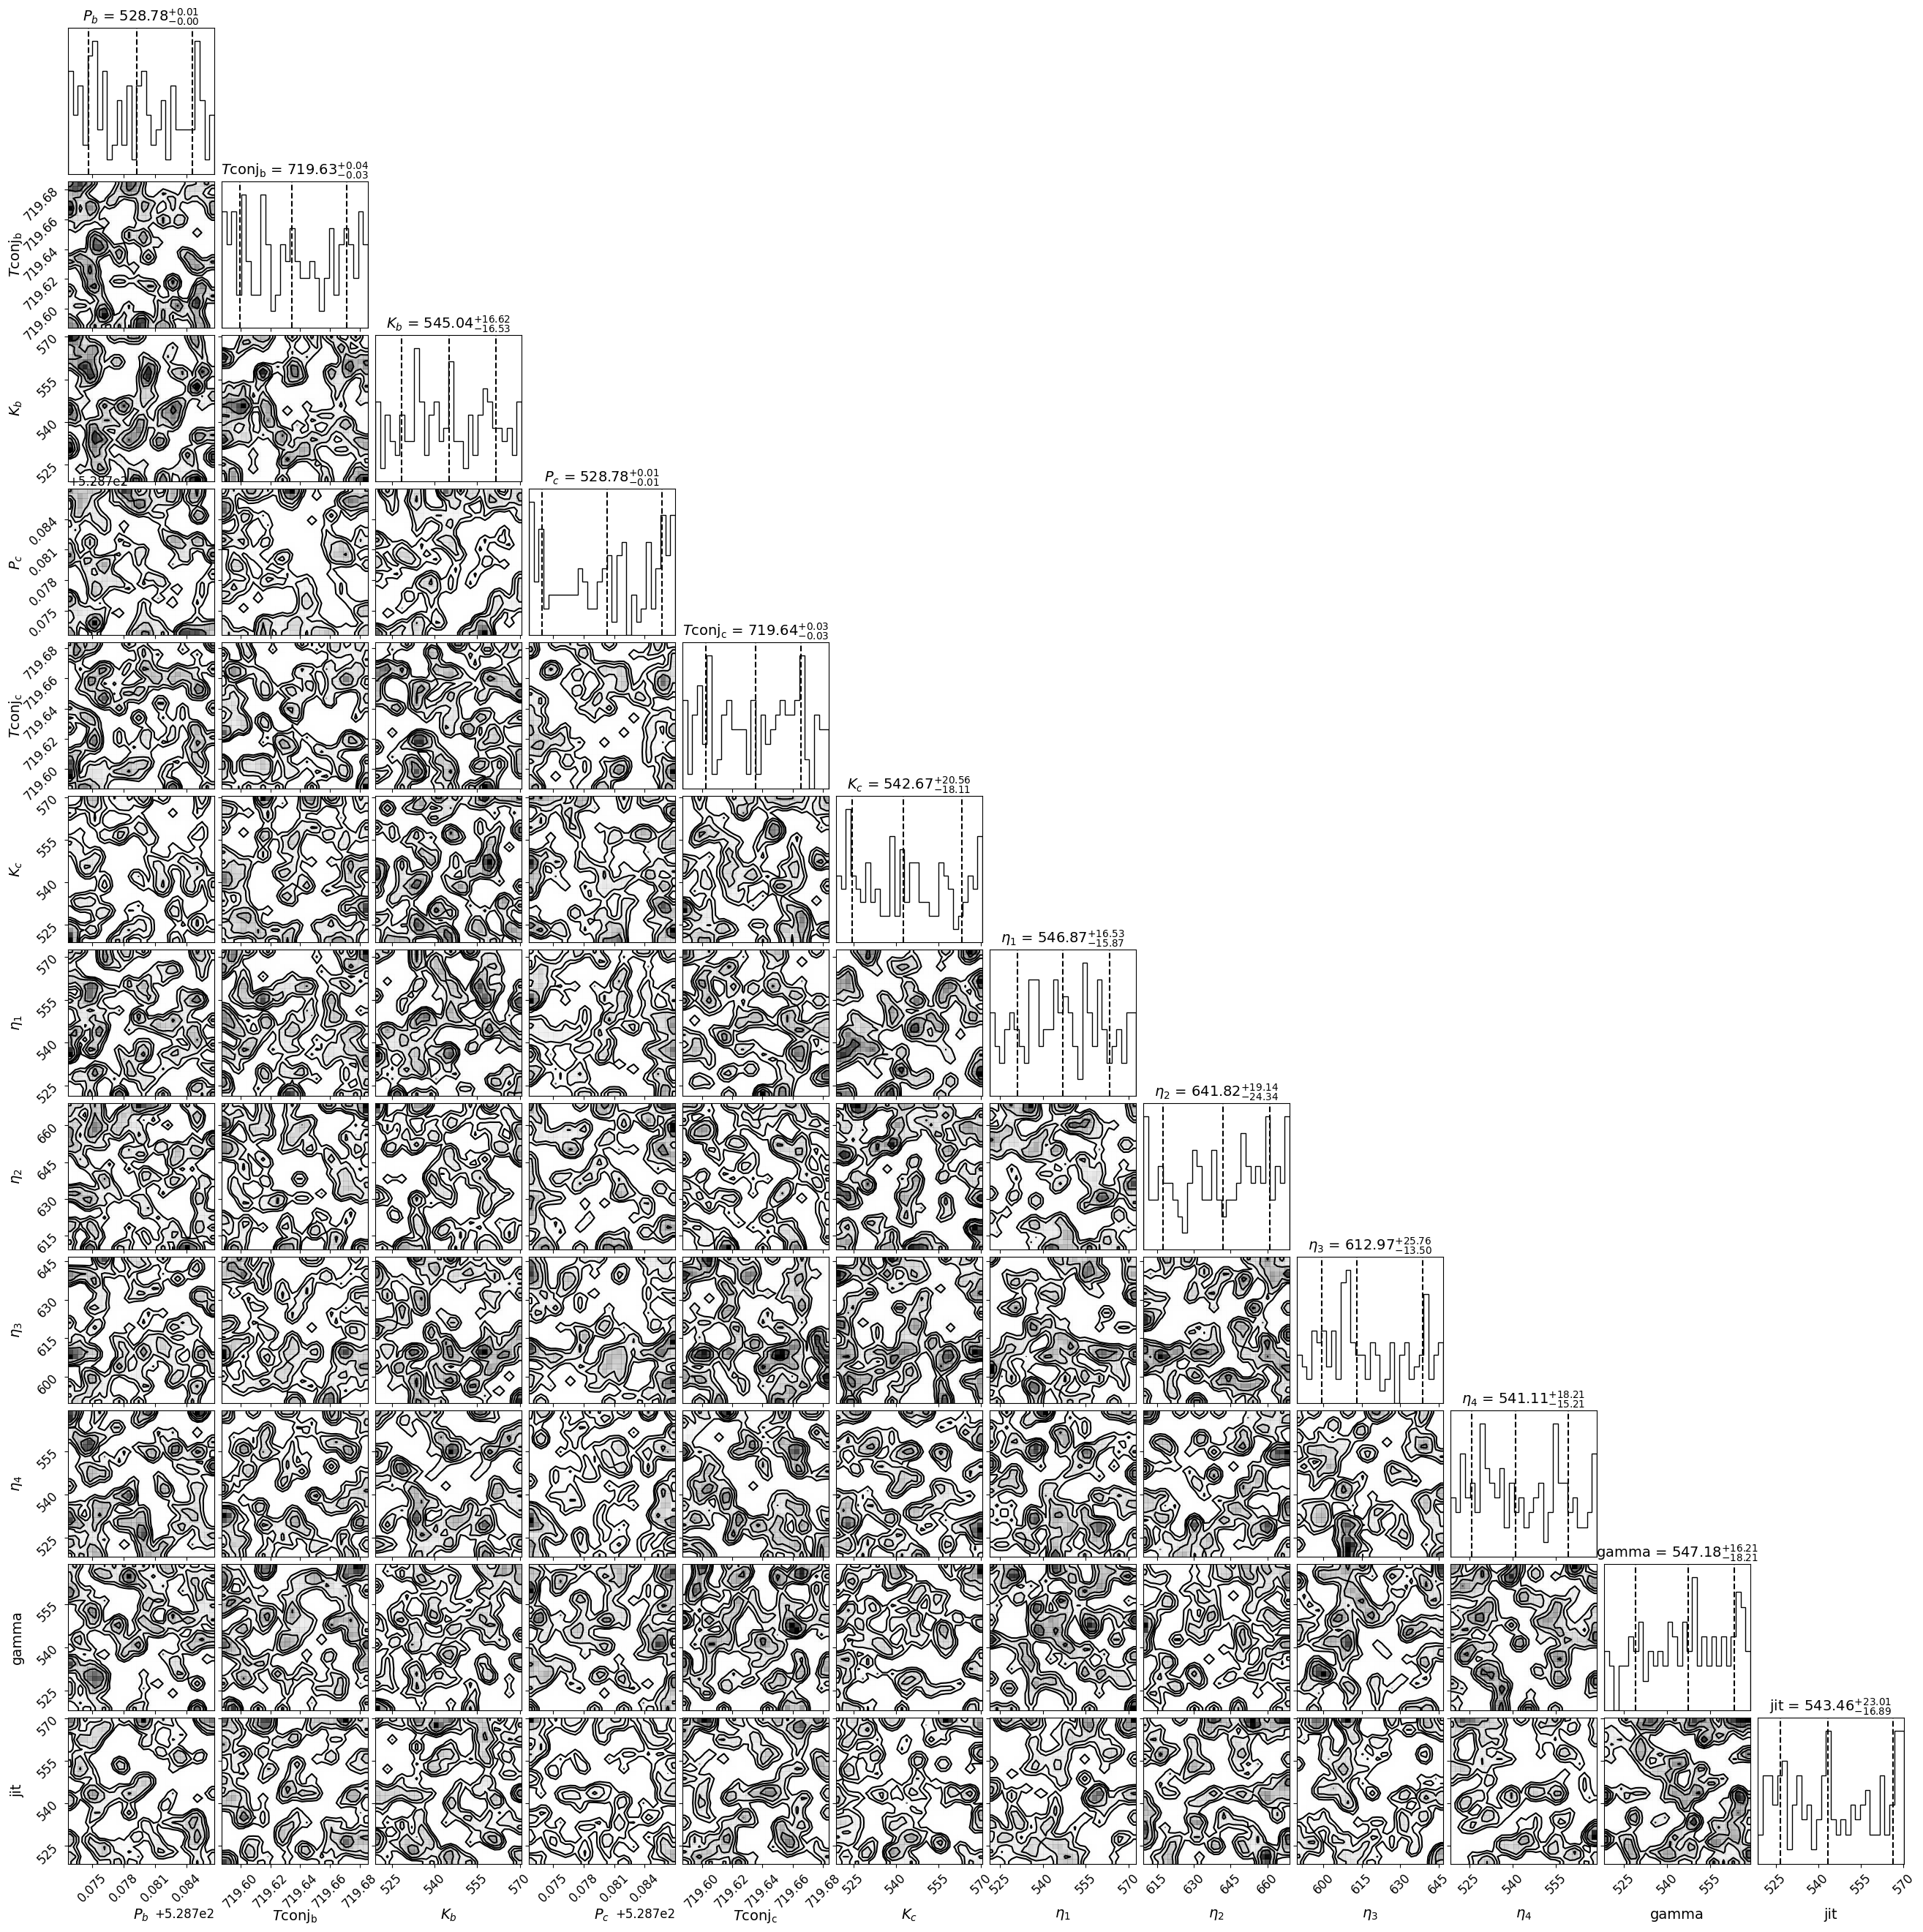

per1 : 528.7793 +/- 0.0049
tc1 : 719.635 +/- 0.036
k1 : 545 +/- 17
per2 : 528.7803 +/- 0.0059
tc2 : 719.636 +/- 0.031
k2 : 543 +/- 19
gp_amp : 547 +/- 16
gp_explength : 642 +/- 22
gp_per : 613 +/- 20
gp_perlength : 541 +/- 17
gamma : 547 +/- 17
jit : 543 +/- 20


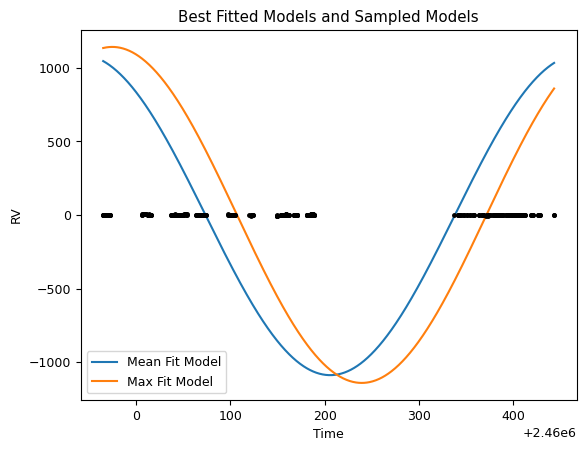

ALL DONE!


In [99]:
Corner = mcmc_plots.CornerPlot(post, chains)  # posterior distributions
Corner.plot()
plt.savefig(f"stars/{star}/george_radvel/RV/1_planet+GP_cornerplot.png")


quants = chains.quantile(
    [0.159, 0.5, 0.841]
)  # median & 1sigma limits of posterior distributions
for par in post.params.keys():
    if post.params[par].vary:
        med = quants[par][0.5]
        high = quants[par][0.841] - med
        low = med - quants[par][0.159]
        err = np.mean([high, low])
        err = radvel.utils.round_sig(err)
        med, err, errhigh = radvel.utils.sigfig(med, err)
        print("{} : {} +/- {}".format(par, med, err))

N_samples = 3
# Get the best-fit model
mean_fit_params = chains.mean()
max_fit_params = chains.max()
mean_fit_params = dict(mean_fit_params)
max_fit_params = dict(max_fit_params)

mean_params = radvel.Parameters(RV_priors['nplanets'], basis="per tc secosw sesinw k")
max_params = radvel.Parameters(RV_priors['nplanets'], basis="per tc secosw sesinw k")

#Transfer the parameters to the RadVel parameters object
for i in range(RV_priors['nplanets']):
    mean_params["per{}".format(i + 1)] = radvel.Parameter(value=mean_fit_params["per{}".format(i + 1)], vary=False)
    mean_params["tc{}".format(i + 1)] = radvel.Parameter(value=mean_fit_params["tc{}".format(i + 1)], vary=False)
    mean_params["secosw{}".format(i + 1)] = radvel.Parameter(value=0, vary=False)
    mean_params["sesinw{}".format(i + 1)] = radvel.Parameter(value=0, vary=False)
    mean_params["k{}".format(i + 1)] = radvel.Parameter(value=mean_fit_params["k{}".format(i + 1)], vary=False)
    mean_params["dvdt"] = radvel.Parameter(value=0, vary=False)
    mean_params["curv"] = radvel.Parameter(value=0, vary=False)
    mean_params["gamma"] = radvel.Parameter(value=mean_fit_params["gamma"], vary=False)
    mean_params["jit"] = radvel.Parameter(value=mean_fit_params["jit"], vary=False)
    mean_params["gp_amp"] = radvel.Parameter(value=mean_fit_params["gp_amp"], vary=False)
    mean_params["gp_explength"] = radvel.Parameter(value=mean_fit_params["gp_explength"], vary=False)
    mean_params["gp_per"] = radvel.Parameter(value=mean_fit_params["gp_per"], vary=False)
    mean_params["gp_perlength"] = radvel.Parameter(value=mean_fit_params["gp_perlength"], vary=False)

    max_params["per{}".format(i + 1)] = radvel.Parameter(value=max_fit_params["per{}".format(i + 1)], vary=False)
    max_params["tc{}".format(i + 1)] = radvel.Parameter(value=max_fit_params["tc{}".format(i + 1)], vary=False)
    max_params["secosw{}".format(i + 1)] = radvel.Parameter(value=0, vary=False)
    max_params["sesinw{}".format(i + 1)] = radvel.Parameter(value=0, vary=False)
    max_params["k{}".format(i + 1)] = radvel.Parameter(value=max_fit_params["k{}".format(i + 1)], vary=False)
    max_params["dvdt"] = radvel.Parameter(value=0, vary=False)
    max_params["curv"] = radvel.Parameter(value=0, vary=False)
    max_params["gamma"] = radvel.Parameter(value=max_fit_params["gamma"], vary=False)
    max_params["jit"] = radvel.Parameter(value=max_fit_params["jit"], vary=False)
    max_params["gp_amp"] = radvel.Parameter(value=max_fit_params["gp_amp"], vary=False)
    max_params["gp_explength"] = radvel.Parameter(value=max_fit_params["gp_explength"], vary=False)
    max_params["gp_per"] = radvel.Parameter(value=max_fit_params["gp_per"], vary=False)
    max_params["gp_perlength"] = radvel.Parameter(value=max_fit_params["gp_perlength"], vary=False)
    

mean_fit_model = radvel.model.RVModel(params=mean_params)
max_fit_model = radvel.model.RVModel(params=max_params)

mean_like = radvel.likelihood.GPLikelihood(
    mean_fit_model, t_rv_all, y_rv_all, yerr_rv_all, hnames, kernel_name="QuasiPer"
)

max_like = radvel.likelihood.GPLikelihood(
    max_fit_model, t_rv_all, y_rv_all, yerr_rv_all, hnames, kernel_name="QuasiPer"
)

# Plot the best-fitted model
plt.errorbar(
    t_rv_all, y_rv_all, yerr=yerr_rv_all, fmt=".k"
)
plt.plot(t_mod[instrument], mean_fit_model(t_mod[instrument]), label='Mean Fit Model')
plt.plot(t_mod[instrument], max_fit_model(t_mod[instrument]), label='Max Fit Model')

# Draw samples from the chains and plot
for i in range(N_samples):
    random_chain_idx = np.random.randint(len(chains))
    random_fit_params = chains.iloc[random_chain_idx]
    random_params = radvel.Parameters(RV_priors['nplanets'], basis="per tc secosw sesinw k")
    
    random_params["per1"] = radvel.Parameter(value=random_fit_params["per1"], vary=False)
    random_params["tc1"] = radvel.Parameter(value=random_fit_params["tc1"], vary=False)
    random_params["secosw1"] = radvel.Parameter(value=0, vary=False)
    random_params["sesinw1"] = radvel.Parameter(value=0, vary=False)
    random_params["k1"] = radvel.Parameter(value=random_fit_params["k1"], vary=False)
    random_params["dvdt"] = radvel.Parameter(value=0, vary=False)
    random_params["curv"] = radvel.Parameter(value=0, vary=False)
    random_params["gamma"] = radvel.Parameter(value=random_fit_params["gamma"], vary=False)
    random_params["jit"] = radvel.Parameter(value=random_fit_params["jit"], vary=False)
    random_params["gp_amp"] = radvel.Parameter(value=random_fit_params["gp_amp"], vary=False)
    random_params["gp_explength"] = radvel.Parameter(value=random_fit_params["gp_explength"], vary=False)
    random_params["gp_per"] = radvel.Parameter(value=random_fit_params["gp_per"], vary=False)
    random_params["gp_perlength"] = radvel.Parameter(value=random_fit_params["gp_perlength"], vary=False)
    
    random_model = radvel.model.RVModel(params=random_params)
    
    plt.plot(t_mod[instrument], random_model(t_mod[instrument]), color="C1", alpha=0.1)
    

plt.legend()
plt.xlabel('Time')
plt.ylabel('RV')
plt.title('Best Fitted Models and Sampled Models')
plt.show()

print('ALL DONE!')

calculate the planet's mass

In [100]:
from radvel.utils import Msini
M_p = Msini(6.9, 18.65, 0.381, 0.0, 'earth')
print(M_p)

15.038349182665915


We're done!

Feel free to modify the code above. Here are a few ideas:
- Try a different GP kernel (both in radvel and for the activity indicator).
- Try building your own GP+planets plots instead of using the RadVel ones
- Try different priors
- Try a differnt orbit parametrization in RadVel
- Test it on another dataset

Ohter frameworks exist to perform the tasks above. Here are a few:
- [Juliet](https://juliet.readthedocs.io/en/latest/): less easy to customize and play
  with the model, but simpler interface and more samplers.
- [exoplanet](https://docs.exoplanet.codes/en/latest/): built on top of PyMC3. This
  makes creating flexible models very easy, PyMC computes gradients for your model
  automatically. This enables using more advanced samplers such as Hamiltonian Monte
  Carlo (HMC) easily.
- [jaxoplanet](https://jax.exoplanet.codes/en/latest/): A version of `exoplanet`
  built on top of `jax` and `numpyro`. These tools cover a similar niche to PyMC,
  but the Jax interface is a bit more intuitive for Jax users, and it can run on GPUs.
  However, `jaxoplanet` is still a WIP and it's not really documented yet.
- Your own code! All of this is fairly simple to implement, you could try implementing
  a code that does it from sratch, or use one that you already have. All the tools
  I mentioend above are open source, so you can look at the code to understand
  the details.